# Linear regression

:::{warning} 

**Under construction**

This notebook comprises various text and code snippets for generating plots and other content for the lectures corresponding to this topic.  It is *not* a coherent set of lecture notes.  Students should refer to the actual lecture slides available on Blackboard.

:::

## (notebook preliminaries)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [191]:
# Make fonts bigger for slides
plt.rcParams['font.size'] = 16

In [112]:
import xarray as xr

# Load the data
filepath_in = "../data/central-park-station-data_1869-01-01_2023-09-30.nc"
ds_cp = xr.open_dataset(filepath_in)

# Clean: drop all 0 values of the temperature fields which are (mostly) spurious
for varname in ["temp_avg", "temp_min", "temp_max"]:
    ds_cp[varname] = ds_cp[varname].where(ds_cp[varname] != 0.)

## Motivation

### Schematics

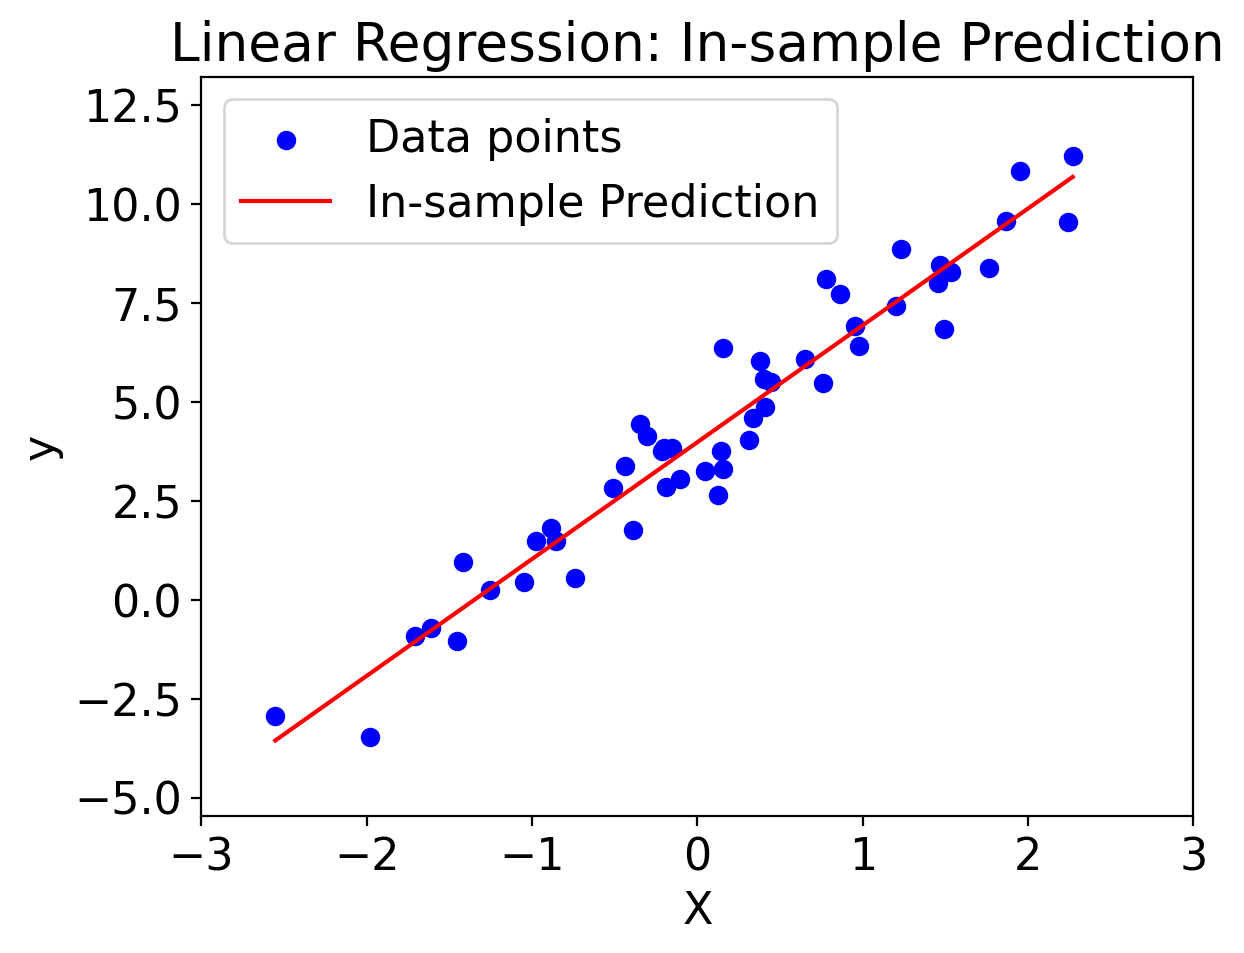

In [201]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Generate random data
np.random.seed(0)
X = np.random.normal(0, 1, 50).reshape(-1, 1)
y = 3 * X.squeeze() + 4 + np.random.normal(0, 1, 50)

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Generate prediction points (in-sample)
X_pred_in_sample = np.linspace(min(X), max(X), 50).reshape(-1, 1)
y_pred_in_sample = model.predict(X_pred_in_sample)

# Plotting
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X_pred_in_sample, y_pred_in_sample, 'r-', label='In-sample Prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.xlim(-3, 3)  # Axis limits from the previous example
plt.ylim(min(y) - 2, max(y) + 2)  # Axis limits from the previous example
plt.legend()
plt.title('Linear Regression: In-sample Prediction')
plt.show()

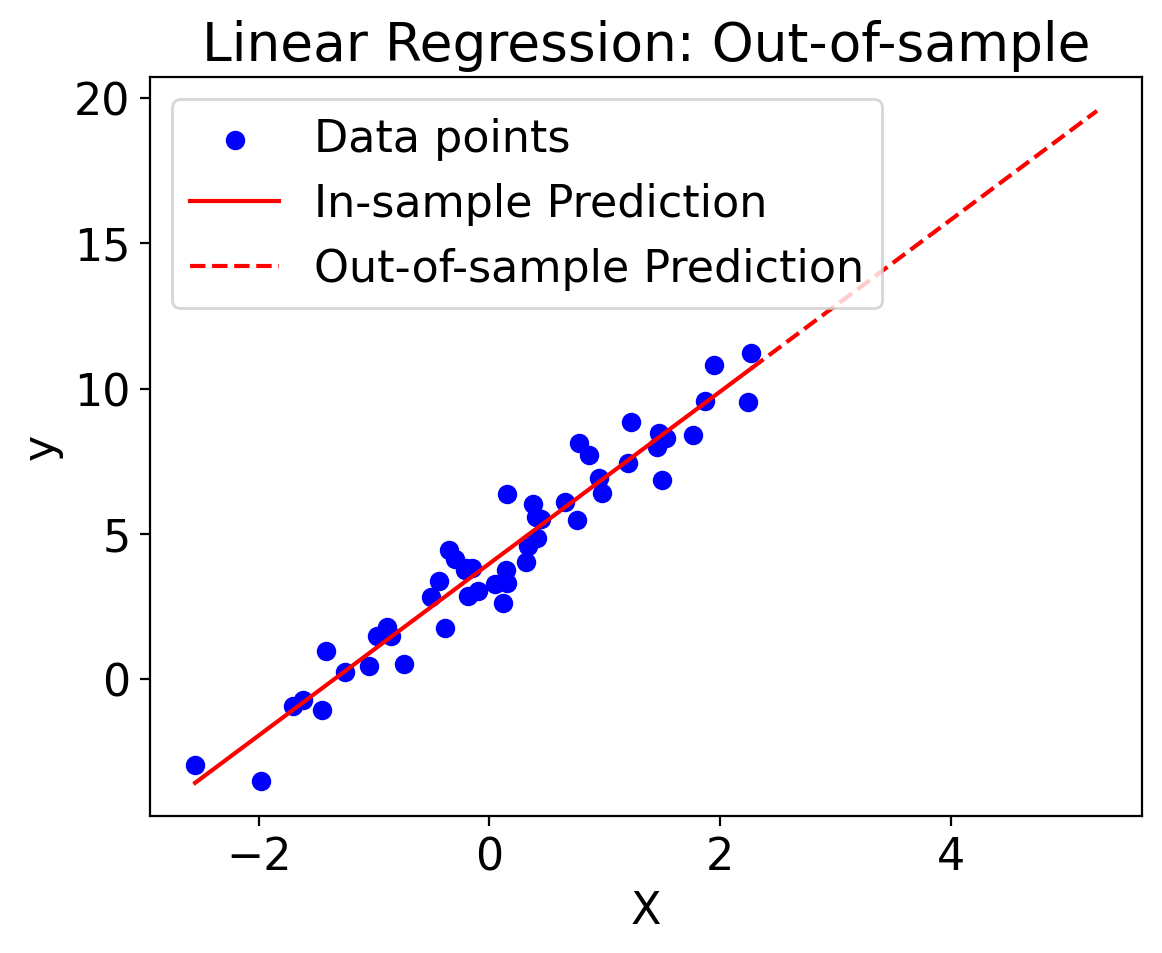

In [204]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Generate random data
np.random.seed(0)
X = np.random.normal(0, 1, 50).reshape(-1, 1)
y = 3 * X.squeeze() + 4 + np.random.normal(0, 1, 50)

# Fit linear regression model
model = LinearRegression()
model.fit(X, y)

# Generate prediction points (both in-sample and out-of-sample)
X_pred_in_sample = np.linspace(min(X), max(X), 50).reshape(-1, 1)
X_pred_out_of_sample = np.linspace(max(X), max(X) + 3, 20).reshape(-1, 1)
y_pred_in_sample = model.predict(X_pred_in_sample)
y_pred_out_of_sample = model.predict(X_pred_out_of_sample)

# Plotting
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X_pred_in_sample, y_pred_in_sample, 'r-', label='In-sample Prediction')
plt.plot(X_pred_out_of_sample, y_pred_out_of_sample, 'r--', label='Out-of-sample Prediction')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.title('Linear Regression: Out-of-sample')
plt.show()

In [110]:
import numpy as np
from bokeh.layouts import row
from bokeh.plotting import figure, show, curdoc
from bokeh.models import ColumnDataSource
import panel as pn

# Generate synthetic data
np.random.seed(0)
X = np.random.normal(0, 1, 50)
y = 3 * X + 4 + np.random.normal(0, 1, 50)

# Set up initial data source and plot
source = ColumnDataSource(data=dict(x=X, y=y))
p = figure(title='Interactive Linear Regression')
p.scatter('x', 'y', source=source, legend_label='Data Points')
line_source = ColumnDataSource(data=dict(x=[], y=[]))
p.line('x', 'y', source=line_source, color='red', legend_label='Regression Line')

# Extend the regression line beyond data points
x_extended = np.linspace(min(X) - 2, max(X) + 2, 50)

def update_line(event):
    slope = slope_slider.value
    intercept = intercept_slider.value
    y_pred = slope * x_extended + intercept
    line_source.data = dict(x=x_extended, y=y_pred)

# Sliders for slope and intercept
slope_slider = pn.widgets.FloatSlider(name='Slope', start=-10, end=10, value=3)
intercept_slider = pn.widgets.FloatSlider(name='Intercept', start=-10, end=10, value=4)

for w in [slope_slider, intercept_slider]:
    w.param.watch(update_line, 'value')

# Initial update
update_line(None)

pn.Column(
    pn.Row(slope_slider, intercept_slider),
    p
)

Column
    [0] Row
        [0] FloatSlider(end=10, name='Slope', start=-10, value=3)
        [1] FloatSlider(end=10, name='Intercept', start=-10, value=4)
    [1] Bokeh(figure)

### Global-mean surface temperature vs. sea-level

In [109]:
import pandas as pd

path_gmst_nasa = "../data/nasa-gmst-ann.txt"
pd.read_csv(path_gmst_nasa)

Year No_Smoothing  Lowess(5)
0       1880     -0.17     -0.10
1       1881     -0.09     -0.13
2       1882     -0.11     -0.17
3       1883     -0.18     -0.21
4       1884     -0.29     -0.24
..                           ...
138     2018      0.85      0.93
139     2019      0.97      0.92
140     2020      1.01      0.91
141     2021      0.84      0.91
142     2022      0.89      0.90

[143 rows x 1 columns]

## Covariance

The first step in understanding linear regression is understanding **covariance**.

### General

In [54]:
import numpy as np

# Number of points
N = 1000

# Mean and standard deviation for X and Y
mean_X, mean_Y = 0, 0
std_X, std_Y = 1, 1

# Specified covariance
cov_XY = 0.5

# Covariance matrix
cov_matrix = [[std_X**2, cov_XY], [cov_XY, std_Y**2]]

# Generate X and Y with the specified covariance
X, Y = np.random.multivariate_normal([mean_X, mean_Y], cov_matrix, N).T

# Verify covariance
computed_cov = np.cov(X, Y)[0, 1]
print("Computed covariance:", computed_cov)

Computed covariance: 0.4884784873002697


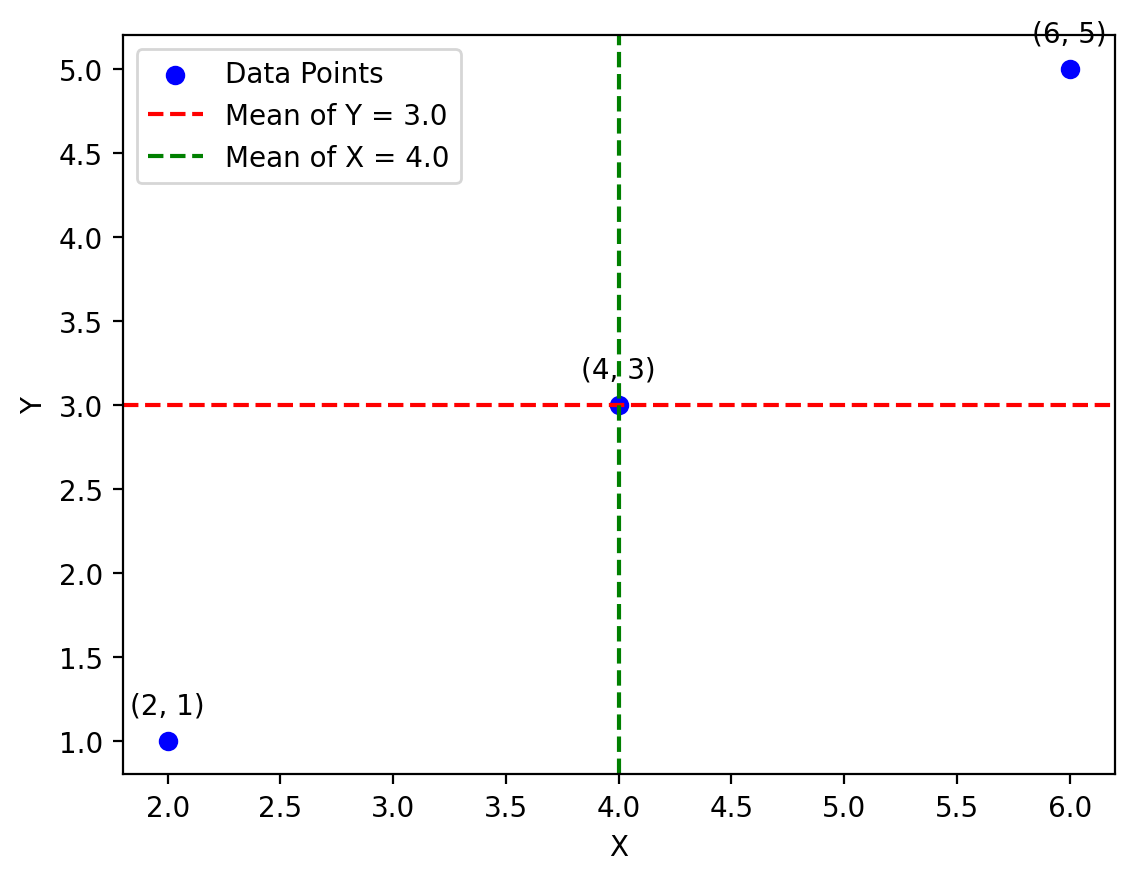

In [175]:
import numpy as np
import matplotlib.pyplot as plt

# Define two arrays of 3 points each
x = np.array([2, 4, 6])
y = np.array([1, 3, 5])

# Calculate means
mean_x = np.mean(x)
mean_y = np.mean(y)

# Create the plot
fig, ax = plt.subplots()
ax.scatter(x, y, label='Data Points', color='b')
ax.axhline(mean_y, color='r', linestyle='--', label=f'Mean of Y = {mean_y}')
ax.axvline(mean_x, color='g', linestyle='--', label=f'Mean of X = {mean_x}')

# Annotate individual points
for i, (xi, yi) in enumerate(zip(x, y)):
    ax.annotate(f'({xi}, {yi})', (xi, yi), textcoords="offset points", xytext=(0,10), ha='center')

# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

plt.show()

Row
    [0] Param(CovariancePlot, widgets={'cov': <class 'panel.widg...})
    [1] ParamMethod(method, _pane=Matplotlib, defer_load=False)
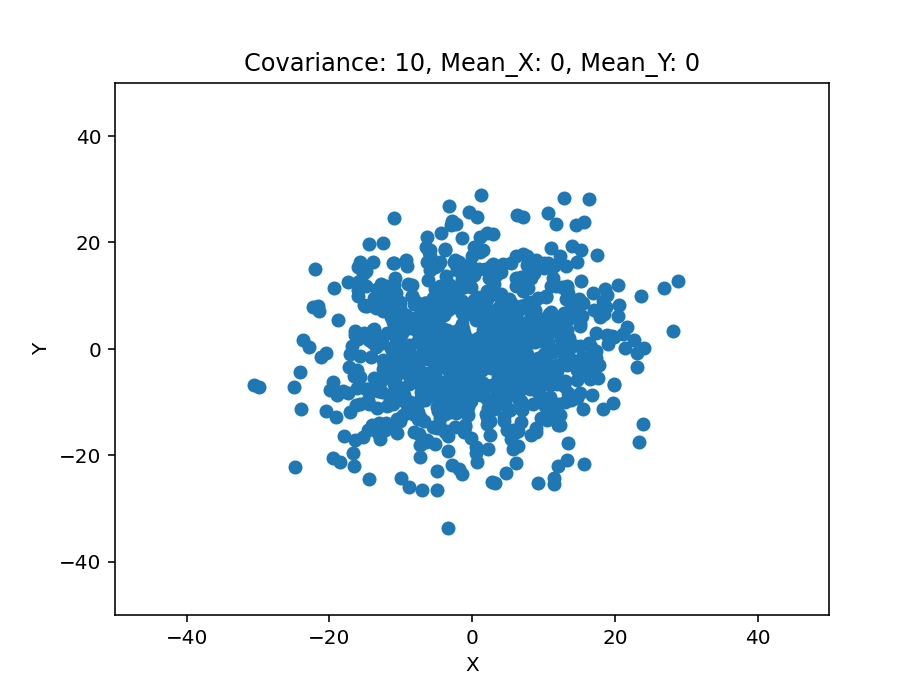

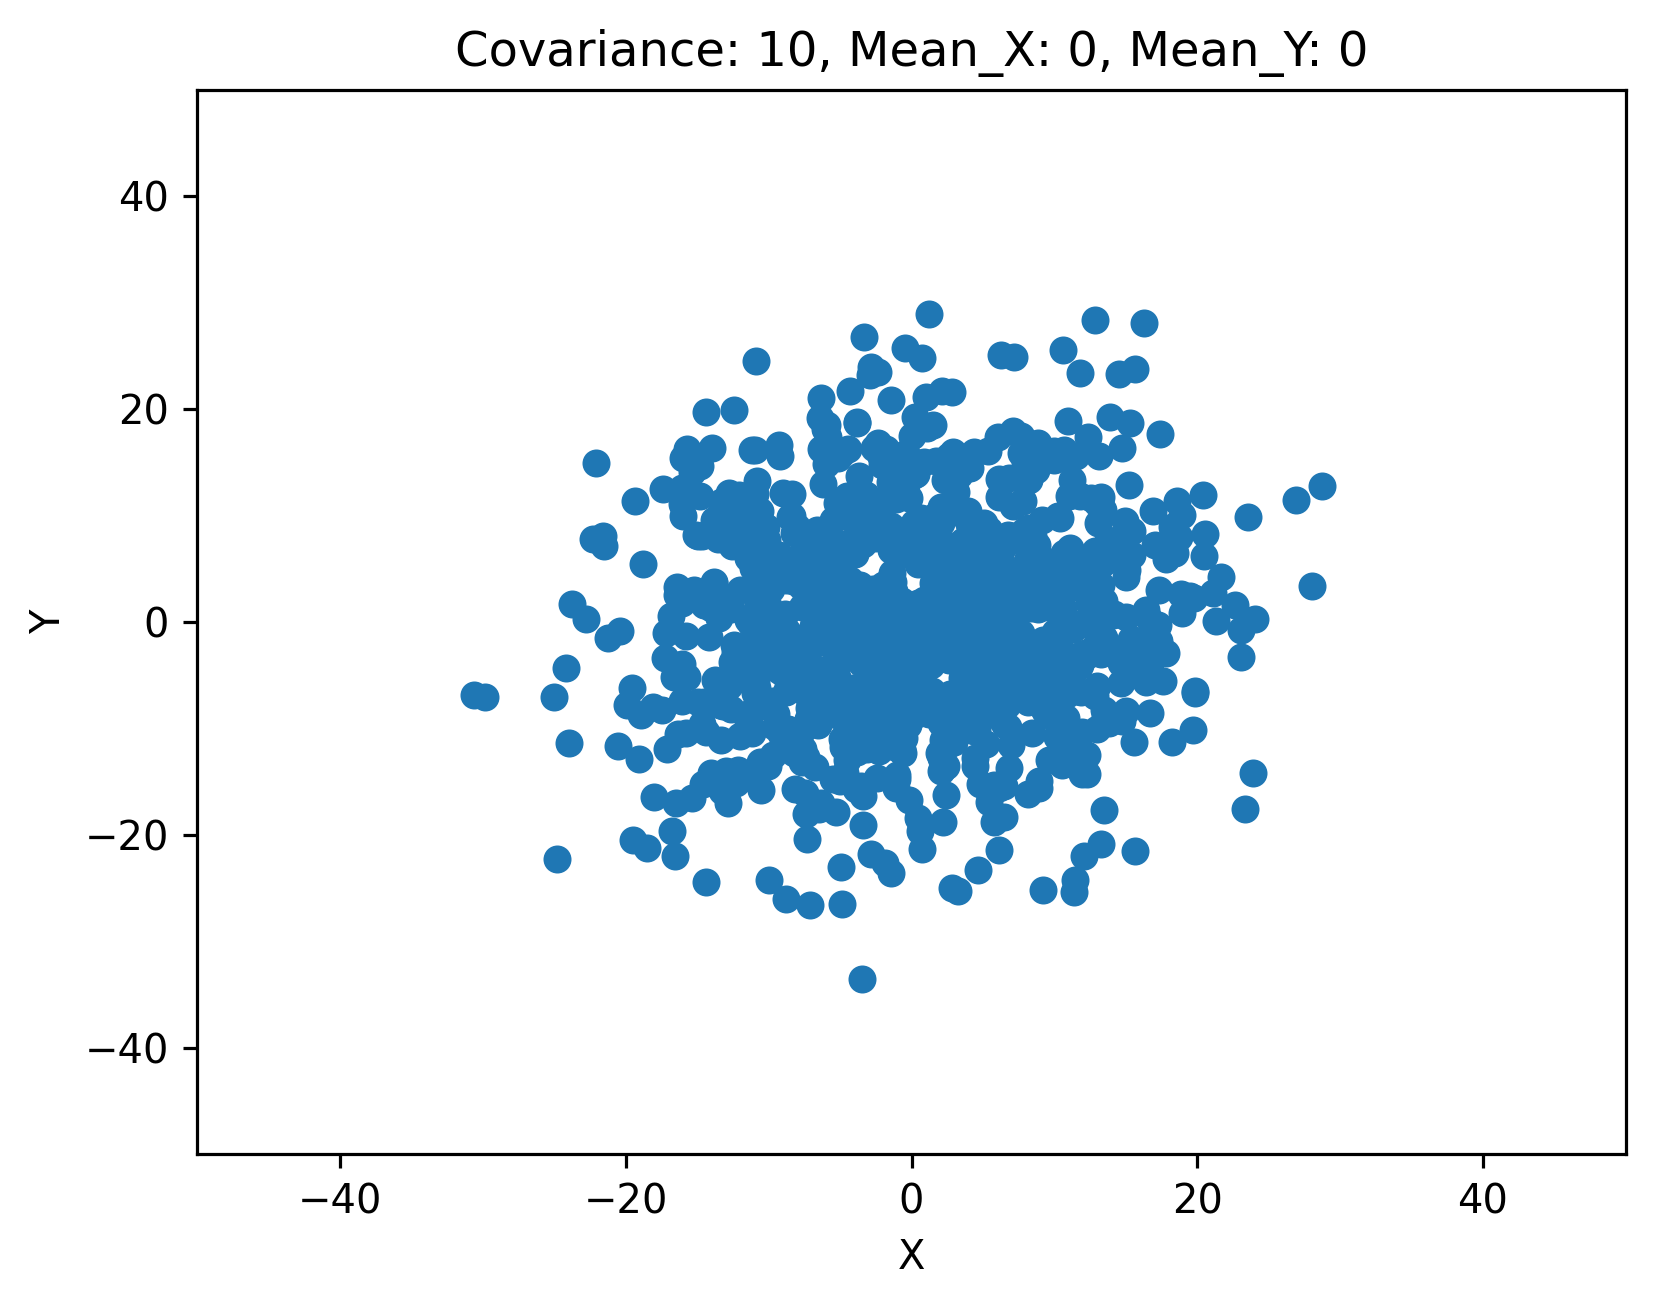

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import panel as pn
import param

class CovariancePlot(param.Parameterized):
    cov = param.Number(10, bounds=(-50, 50))
    mean_x = param.Number(0, bounds=(-10, 10))
    mean_y = param.Number(0, bounds=(-10, 10))
    
    def plot(self):
        np.random.seed(0)
        N = 1000

        cov_matrix = [[100, self.cov], 
                      [self.cov, 100]]

        X, Y = np.random.multivariate_normal([self.mean_x, self.mean_y], cov_matrix, N).T
        
        fig, ax = plt.subplots()
        ax.scatter(X, Y)
        ax.set_xlim(-50, 50)
        ax.set_ylim(-50, 50)
        ax.set_title(f'Covariance: {self.cov}, Mean_X: {self.mean_x}, Mean_Y: {self.mean_y}')
        plt.xlabel('X')
        plt.ylabel('Y')

        return fig

cov_plot = CovariancePlot()
pn.Row(pn.Param(cov_plot.param, widgets={'cov': pn.widgets.FloatSlider, 'mean_x': pn.widgets.FloatSlider, 'mean_y': pn.widgets.FloatSlider}),
       pn.panel(cov_plot.plot))

### Central Park data

Text(0, 0.5, 'max temp. [F]')

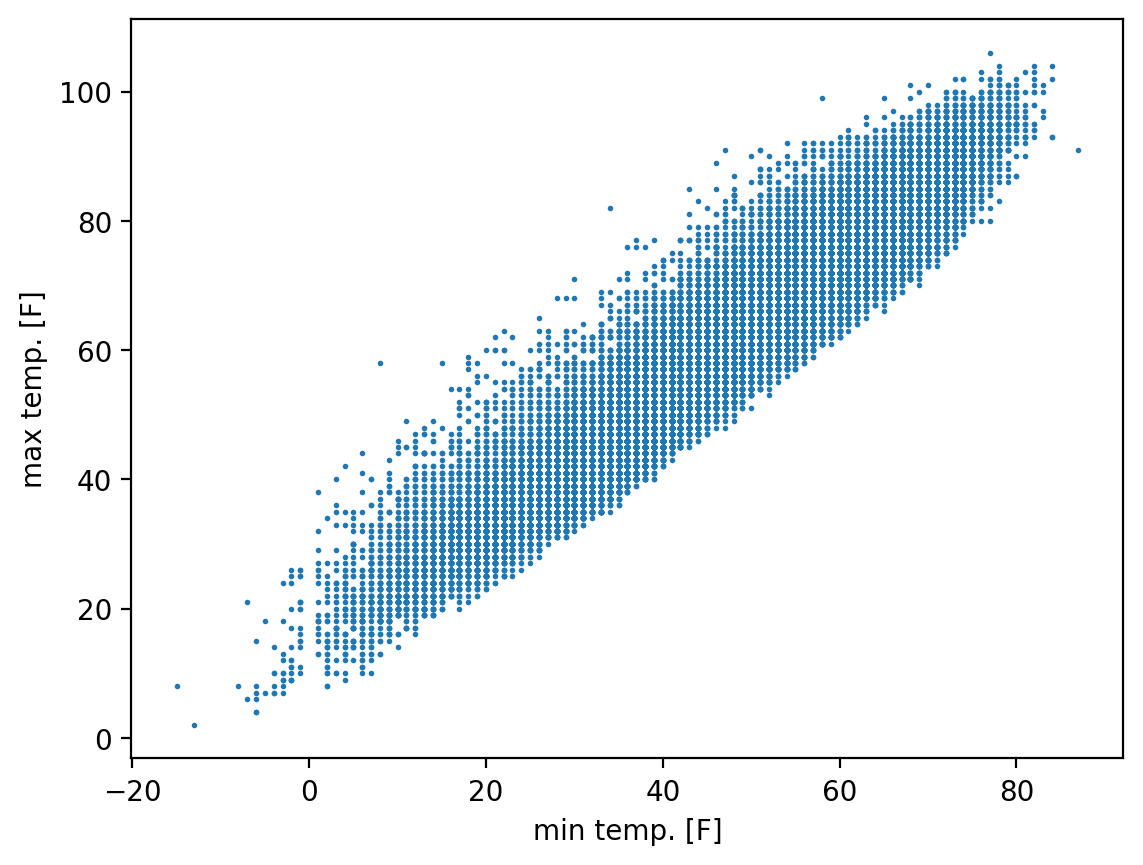

In [119]:
fig, ax = plt.subplots()
ax.scatter(ds_cp["temp_min"], ds_cp["temp_max"], s=1)
ax.set_xlabel("min temp. [F]")
ax.set_ylabel("max temp. [F]")

In [179]:
float(xr.cov(
    ds_cp["temp_min"], 
    ds_cp["temp_max"]))

302.73222593210903

In [150]:
import puffins as pf
pf.stats.lin_regress(ds_cp["precip"].where(ds_cp["snow_fall"] > 0, drop=True), ds_cp["snow_fall"].where(
    ds_cp["snow_fall"] > 0, drop=True), "time").sel(parameter="r_value")

<xarray.DataArray ()>
array(0.53028817)
Coordinates:
    parameter  <U9 'r_value'

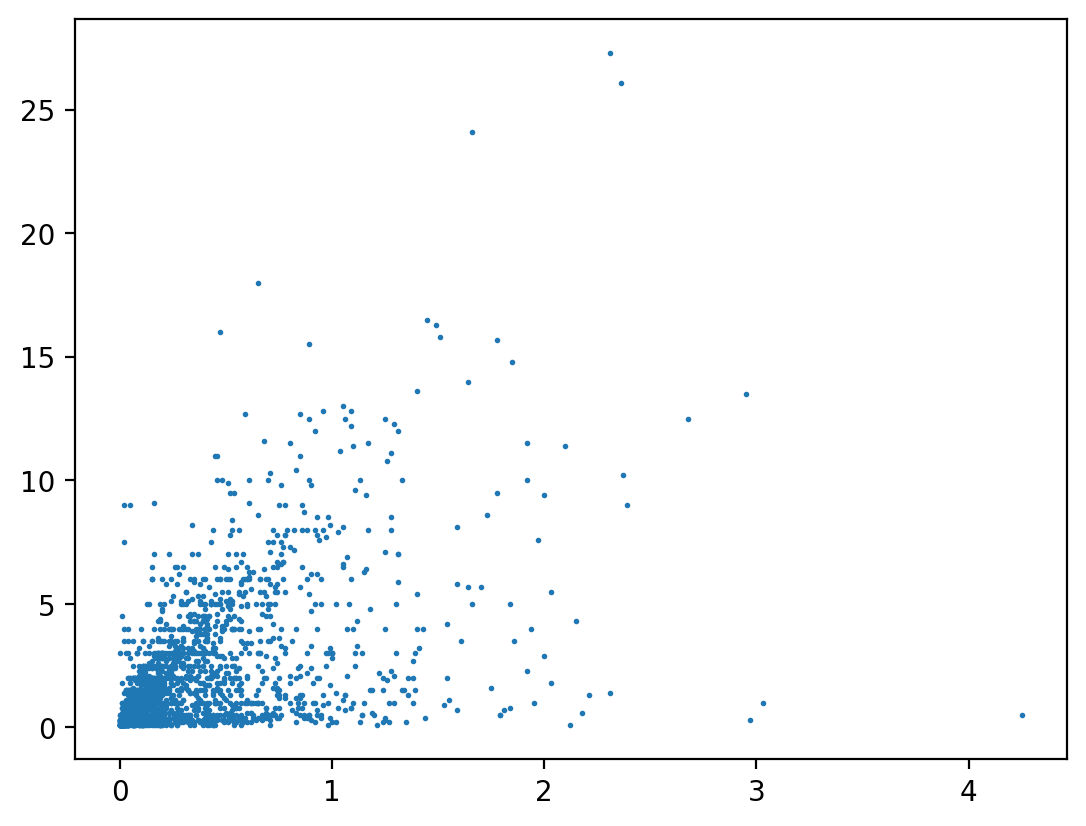

In [146]:
fig, ax = plt.subplots()
ax.scatter(ds_cp["precip"], ds_cp["snow_fall"].where(ds_cp["snow_fall"] > 0), s=1)

## Correlation

Covariance provides a dimensional, quantitative measure of how much two variables tend to vary in sync with one another.  But it is impossible to directly compare the covariance between pairs of variables that do not have the same pysical dimensions.

**Correlation** provides a dimensionless measure of how closely related two variables are, and one that can be 

### Pearson correlation coefficient ($r$)

In essence, the Pearson correlation coefficient is simply the covariance between two variables, but then normalized by the product of each variable's individual variance.

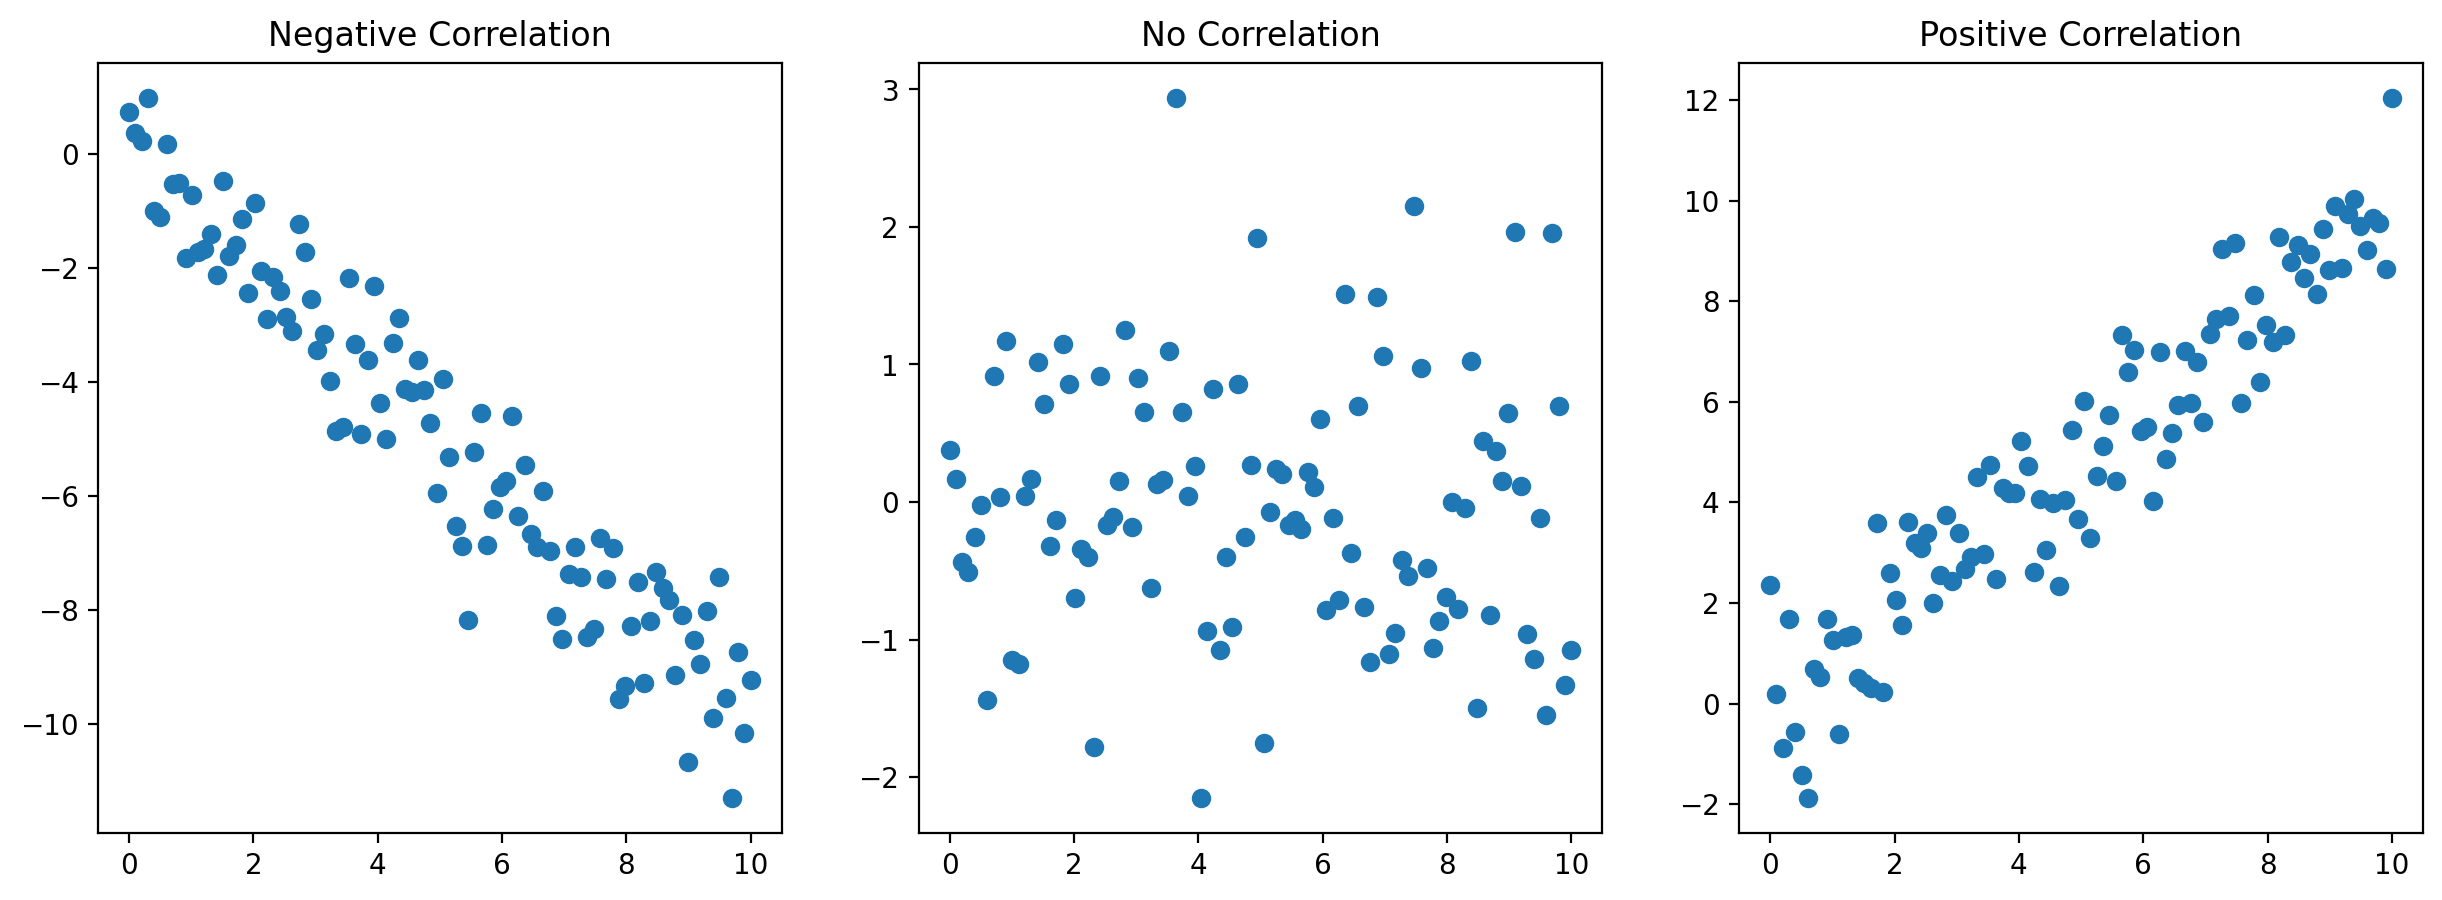

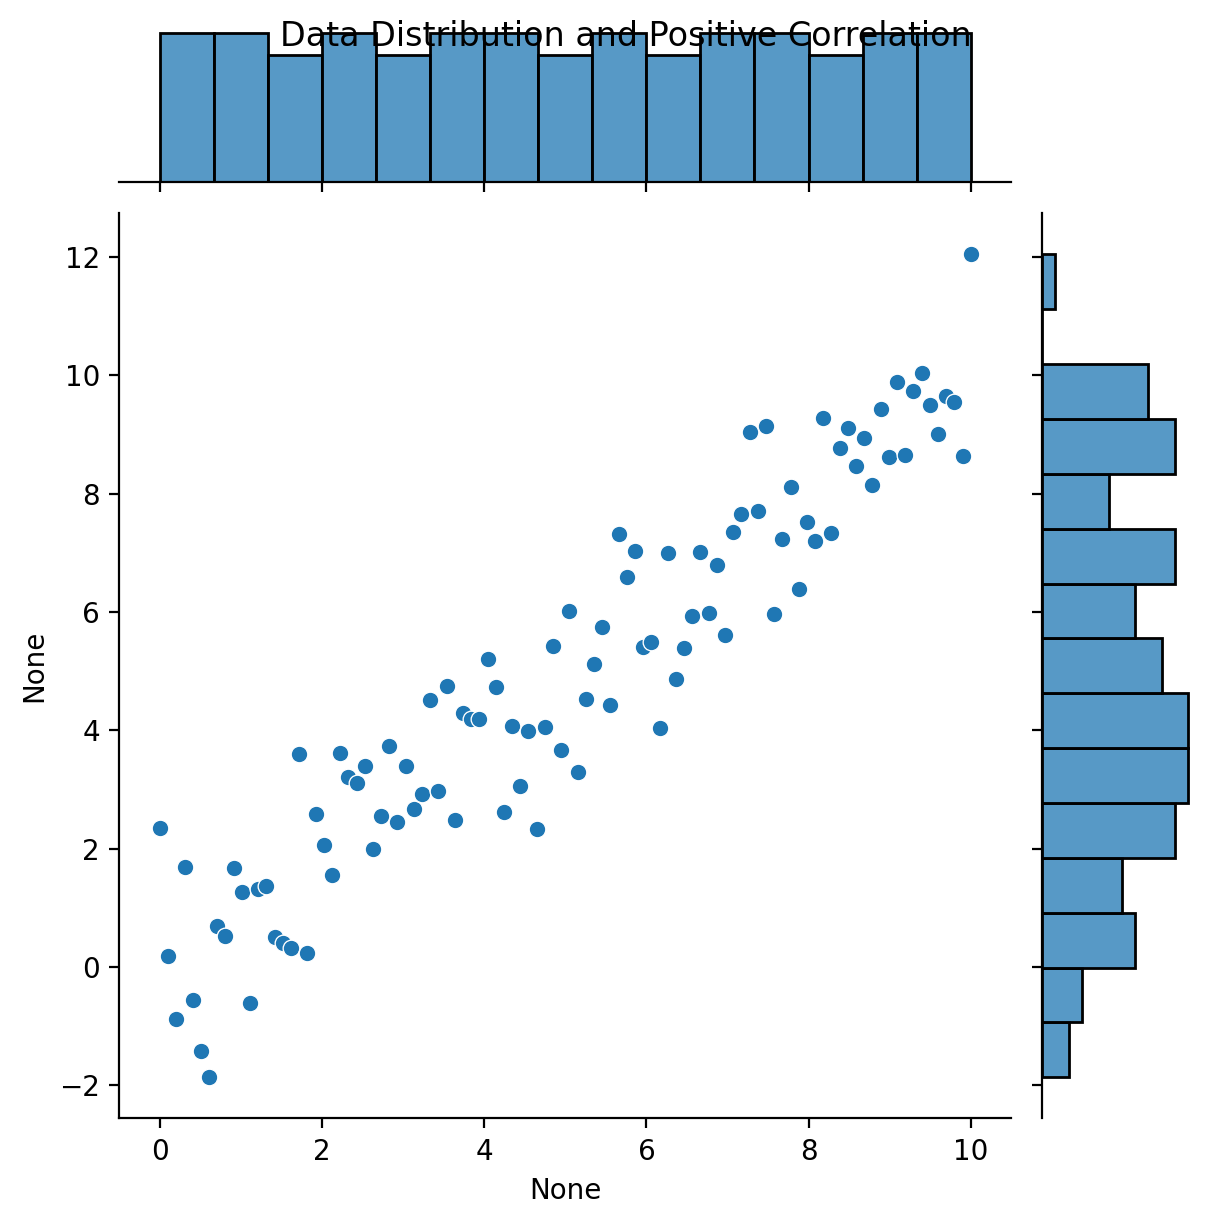

In [3]:
# Scatter Plots for Different Pearson Coefficients
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Negative Correlation
x1 = np.linspace(0, 10, 100)
y1 = -x1 + np.random.normal(0, 1, 100)
axs[0].scatter(x1, y1)
axs[0].set_title('Negative Correlation')

# No Correlation
y2 = np.random.normal(0, 1, 100)
axs[1].scatter(x1, y2)
axs[1].set_title('No Correlation')

# Positive Correlation
y3 = x1 + np.random.normal(0, 1, 100)
axs[2].scatter(x1, y3)
axs[2].set_title('Positive Correlation')

plt.show()

# Data Distribution and Correlation using Seaborn
sns.jointplot(x=x1, y=y3, kind="scatter", marginal_kws=dict(bins=15))
plt.suptitle('Data Distribution and Positive Correlation')
plt.show()

Column
    [0] Markdown(str)
    [1] Column
        [0] Column
            [0] FloatSlider(name='Correlation Coefficient', start=-1, step=0.01)
        [1] Row
            [0] Matplotlib(Figure, name='interactive04777')
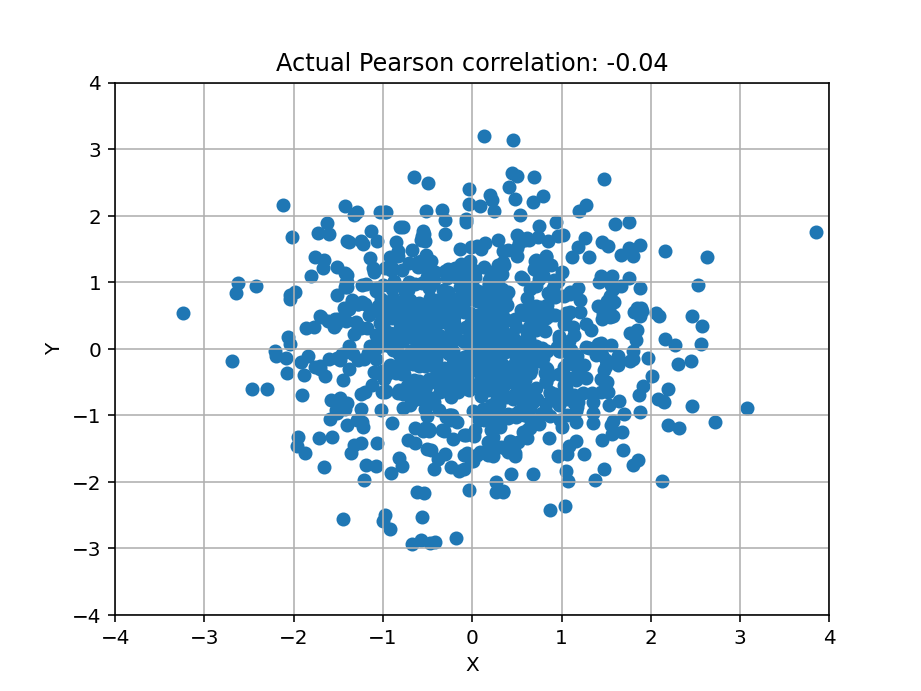

In [183]:
import panel as pn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

pn.extension()

def plot_with_correlation(r=0):
    # Create synthetic data
    np.random.seed(42)
    n = 1000
    x = np.random.randn(n)
    noise = np.random.randn(n)
    y = r*x + np.sqrt(1-r**2)*noise

    # Compute and print actual correlation
    actual_corr, _ = pearsonr(x, y)
    
    # Plotting
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_title(f"Actual Pearson correlation: {actual_corr:.2f}")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.xlim([-4, 4])
    plt.ylim([-4, 4])
    plt.grid(True)
    plt.close(fig)
    return fig

correlation_slider = pn.widgets.FloatSlider(name='Correlation Coefficient', start=-1, end=1, step=0.01, value=0)
interactive_plot = pn.interact(plot_with_correlation, r=correlation_slider)
pn.Column("# Interactive Correlation Coefficient Example", interactive_plot).servable()

Column
    [0] Markdown(str)
    [1] Column
        [0] Column
            [0] FloatSlider(name='Correlation', start=-1.0, step=0.01)
            [1] FloatSlider(end=5.0, name='x scale', start=0.1, value=1.0)
            [2] FloatSlider(end=5.0, name='y scale', start=0.1, value=1.0)
            [3] FloatSlider(end=5.0, name='x offset', start=-5.0)
            [4] FloatSlider(end=5.0, name='y offset', start=-5.0)
        [1] Row
            [0] Matplotlib(Figure, name='interactive05169')
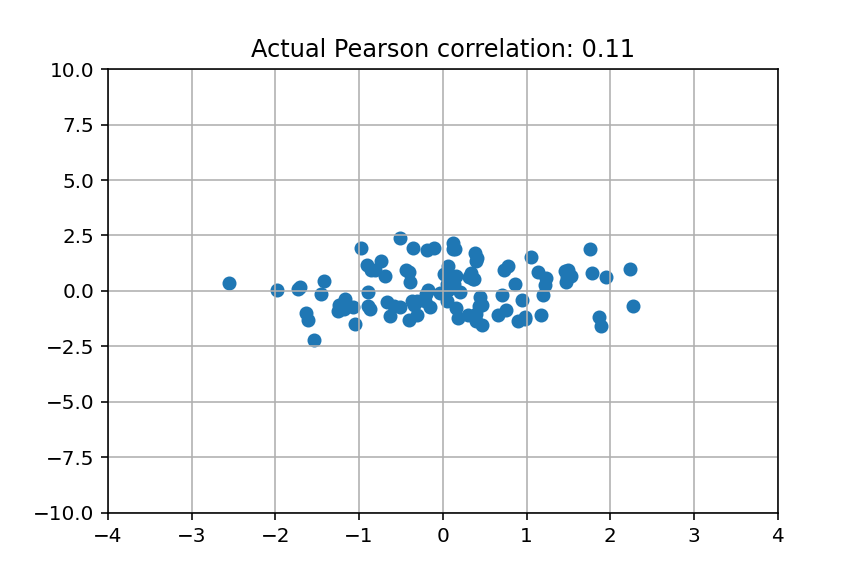

In [184]:
import numpy as np
import matplotlib.pyplot as plt
import panel as pn

pn.extension()

def plot_correlated_data(correlation=0.0, x_scale=1.0, y_scale=1.0, x_offset=0.0, y_offset=0.0):
    np.random.seed(0)
    N = 100
    x = np.random.randn(N)
    x_transformed = x_scale * (x - x_offset)
    noise = np.random.randn(N)
    y = correlation * x_transformed + np.sqrt(1 - correlation ** 2) * noise
    y_transformed = y_scale * (y + y_offset)

    actual_corr, _ = pearsonr(x_transformed, y_transformed)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(x_transformed, y_transformed)
    ax.set_title(f"Actual Pearson correlation: {actual_corr:.2f}")
    ax.set_xlim(-4, 4)
    ax.set_ylim(-10, 10)
    ax.grid(True)
    plt.close(fig)
    return fig

correlation_slider = pn.widgets.FloatSlider(start=-1.0, end=1.0, step=0.01, value=0.0, name='Correlation')
x_scale_slider = pn.widgets.FloatSlider(start=0.1, end=5.0, step=0.1, value=1.0, name='x scale')
y_scale_slider = pn.widgets.FloatSlider(start=0.1, end=5.0, step=0.1, value=1.0, name='y scale')
x_offset_slider = pn.widgets.FloatSlider(start=-5.0, end=5.0, step=0.1, value=0.0, name='x offset')
y_offset_slider = pn.widgets.FloatSlider(start=-5.0, end=5.0, step=0.1, value=0.0, name='y offset')

#interactive_plot = pn.interact(plot_correlated_data, correlation=correlation_slider)
interactive_plot = pn.interact(
    plot_correlated_data,
    correlation=correlation_slider,
    x_scale=x_scale_slider,
    y_scale=y_scale_slider,
    x_offset=x_offset_slider,
    y_offset=y_offset_slider,
)

pn.Column("# Correlation coefficient", interactive_plot).servable()

#### Limitations

##### Correlation does not imply causation: 3rd variable could be driving both

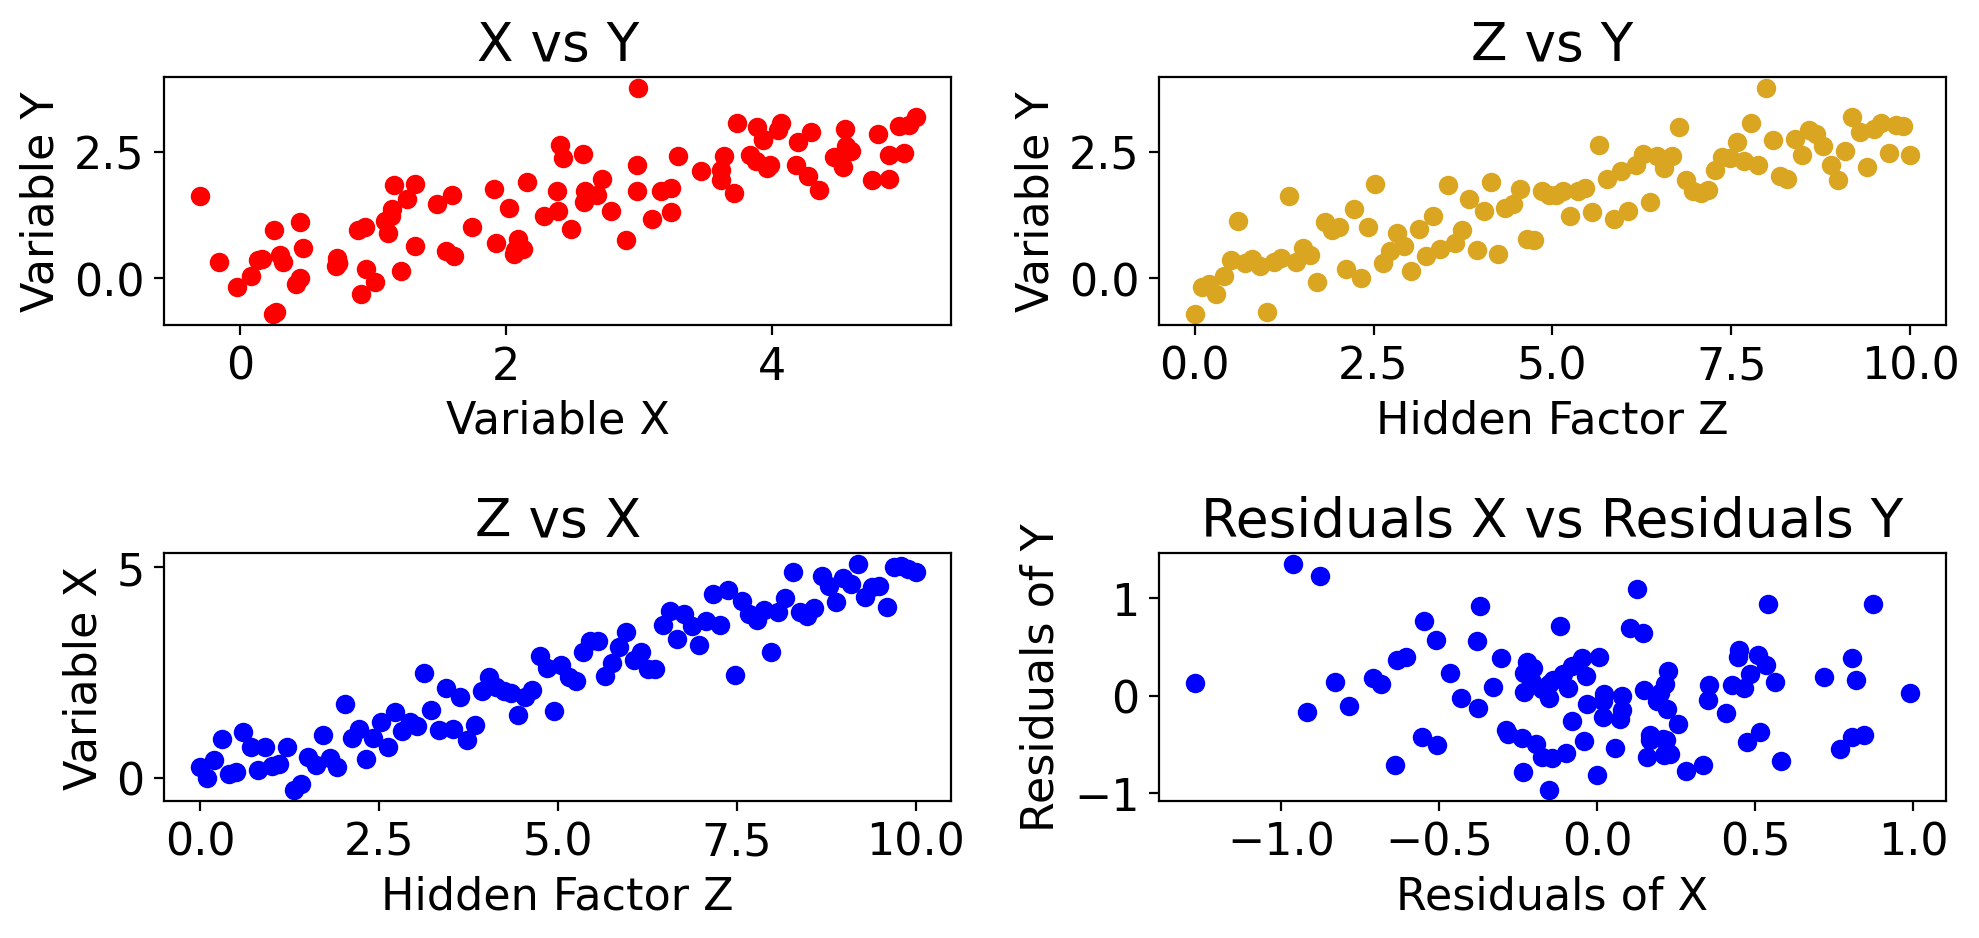

In [221]:
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data
np.random.seed(42)
Z = np.linspace(0, 10, 100)  # Z is the hidden factor that affects both X and Y
X = 0.5 * Z + 0.5*np.random.normal(size=Z.size)  # X is somewhat influenced by Z
Y = 0.3 * Z + 0.5*np.random.normal(size=Z.size)  # Y is also somewhat influenced by Z

# Fit linear models to get residuals
model_X = LinearRegression()
model_X.fit(Z.reshape(-1, 1), X)
residuals_X = X - model_X.predict(Z.reshape(-1, 1))

model_Y = LinearRegression()
model_Y.fit(Z.reshape(-1, 1), Y)
residuals_Y = Y - model_Y.predict(Z.reshape(-1, 1))


# Plotting
fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# Scatter plot for X vs Y showing the apparent correlation
ax = axs[0,0]
ax.scatter(X, Y, color='red')
ax.set_xlabel('Variable X')
ax.set_ylabel('Variable Y')
ax.set_title('X vs Y')

# Scatter plot for Z vs X
ax = axs[1,0]
ax.scatter(Z, X, color='blue')
ax.set_xlabel('Hidden Factor Z')
ax.set_ylabel('Variable X')
ax.set_title('Z vs X')

# Scatter plot for Z vs Y
ax = axs[0,1]
ax.scatter(Z, Y, color='goldenrod')
ax.set_xlabel('Hidden Factor Z')
ax.set_ylabel('Variable Y')
ax.set_title('Z vs Y')

# Scatter plot for Residuals X vs Residuals Y
ax = axs[1,1]
ax.scatter(residuals_X, residuals_Y, color='blue')
ax.set_xlabel('Residuals of X')
ax.set_ylabel('Residuals of Y')
ax.set_title('Residuals X vs Residuals Y')

plt.tight_layout()
plt.show()

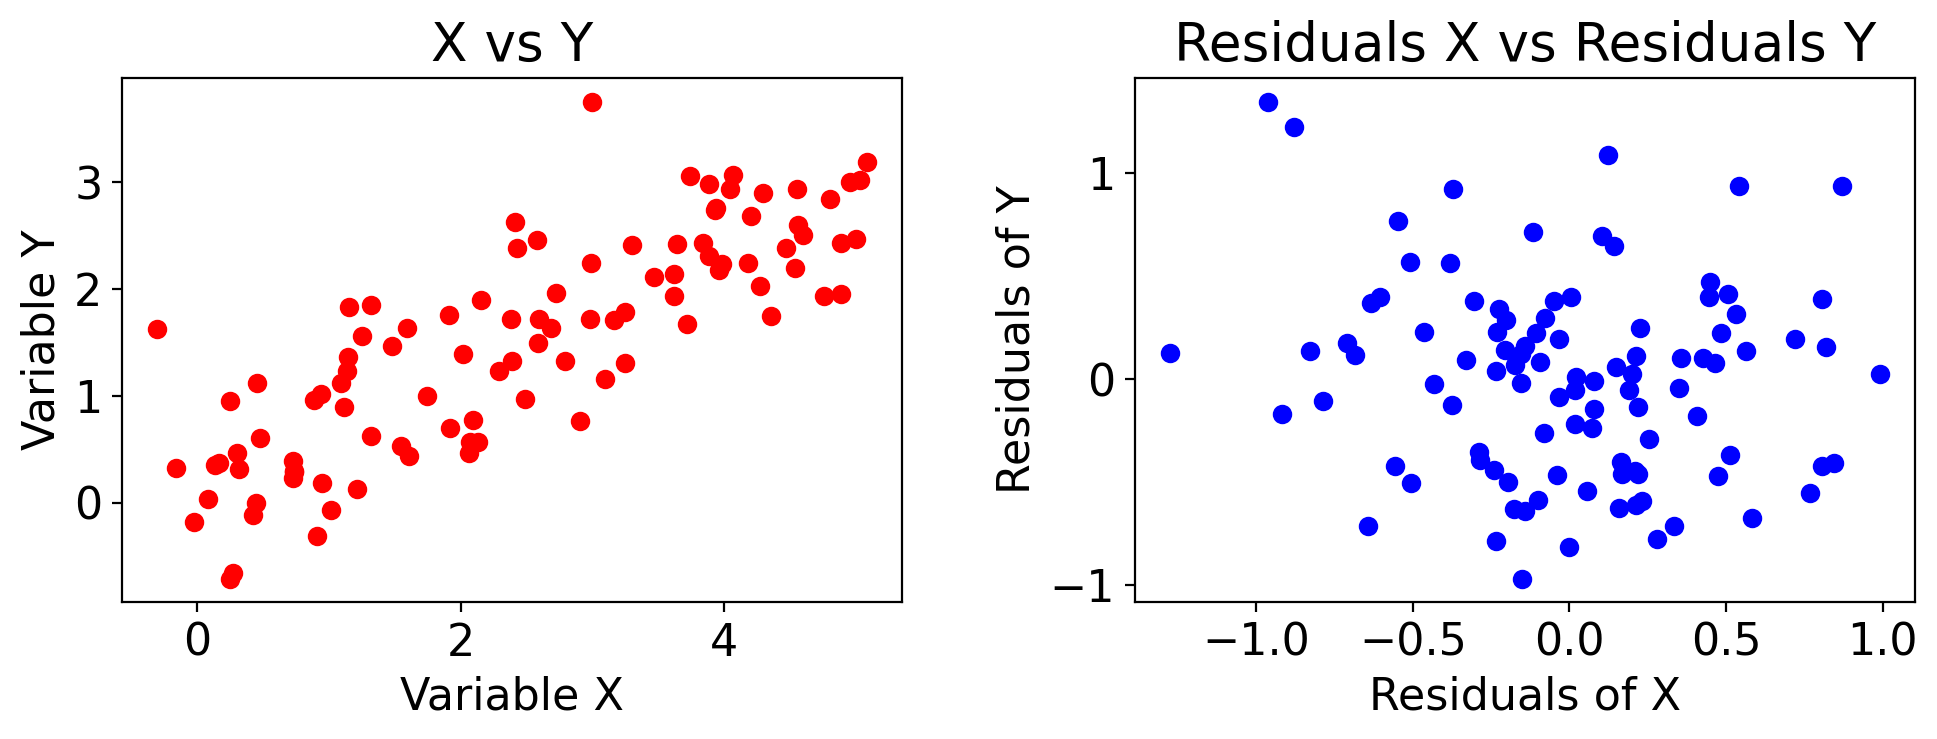

In [214]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Generate synthetic data
np.random.seed(42)
Z = np.linspace(0, 10, 100)  # Z is the hidden factor that affects both X and Y
X = 0.5 * Z + 0.5*np.random.normal(size=Z.size)  # X is somewhat influenced by Z
Y = 0.3 * Z + 0.5*np.random.normal(size=Z.size)  # Y is also somewhat influenced by Z

# Fit linear models to get residuals
model_X = LinearRegression()
model_X.fit(Z.reshape(-1, 1), X)
residuals_X = X - model_X.predict(Z.reshape(-1, 1))

model_Y = LinearRegression()
model_Y.fit(Z.reshape(-1, 1), Y)
residuals_Y = Y - model_Y.predict(Z.reshape(-1, 1))

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Scatter plot for X vs Y
axs[0].scatter(X, Y, color='red')
axs[0].set_xlabel('Variable X')
axs[0].set_ylabel('Variable Y')
axs[0].set_title('X vs Y')

# Scatter plot for Residuals X vs Residuals Y
axs[1].scatter(residuals_X, residuals_Y, color='blue')
axs[1].set_xlabel('Residuals of X')
axs[1].set_ylabel('Residuals of Y')
axs[1].set_title('Residuals X vs Residuals Y')

plt.tight_layout()
plt.show()

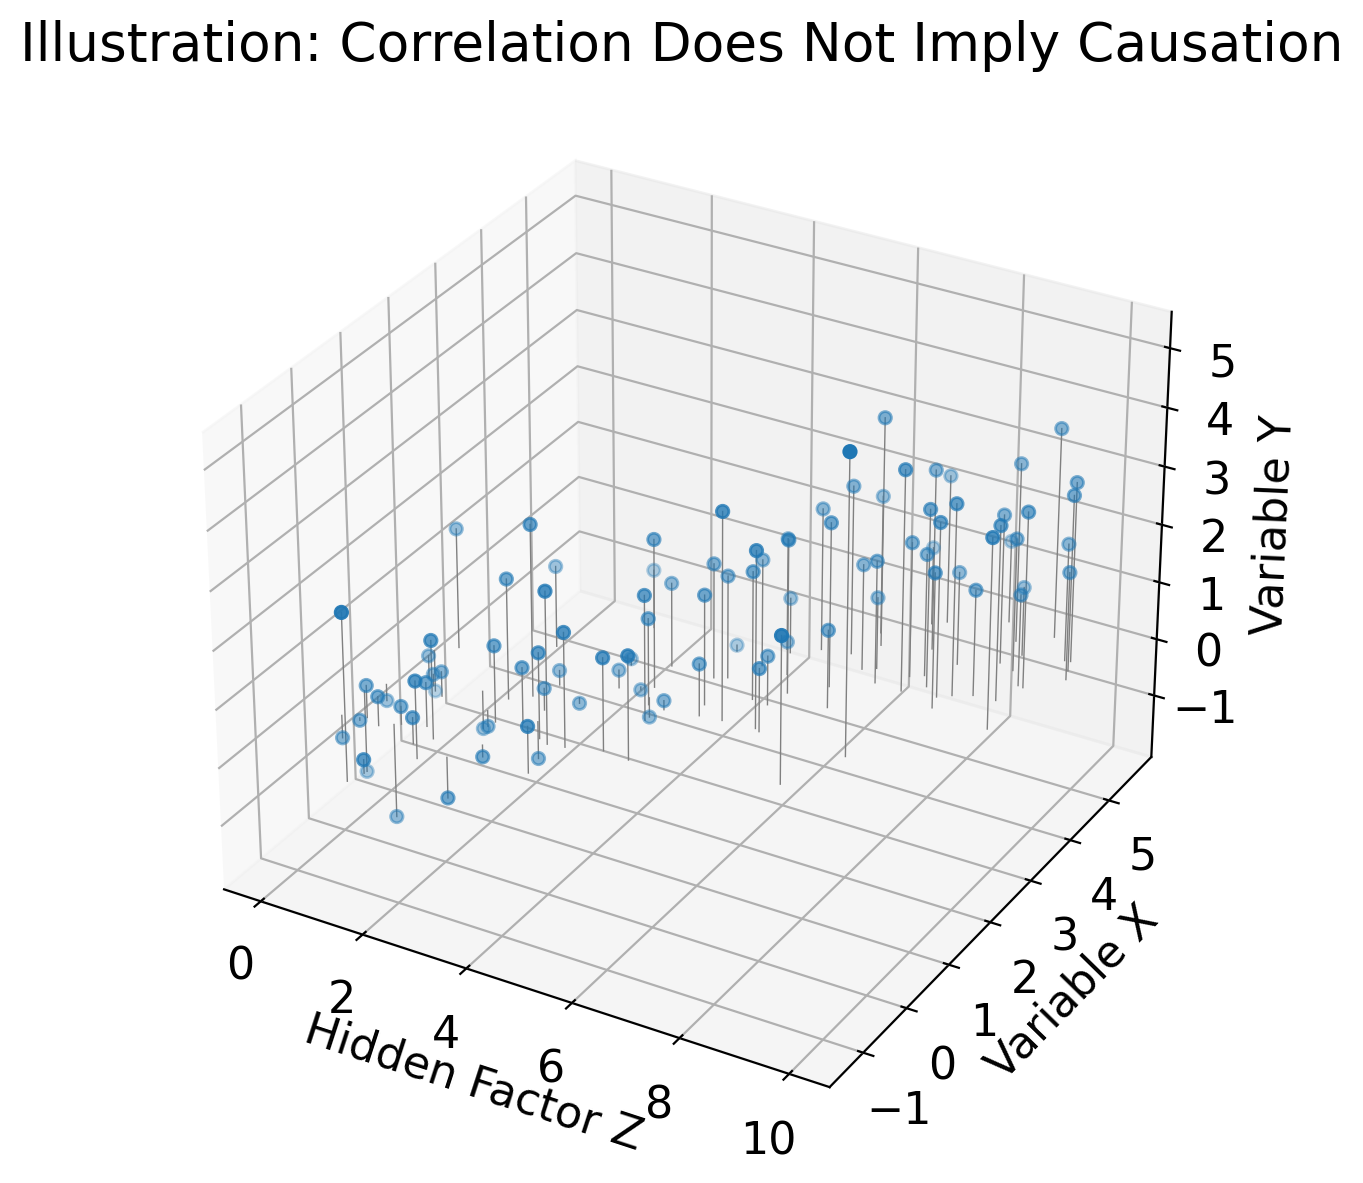

In [210]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Generate synthetic data
np.random.seed(42)
Z = np.linspace(0, 10, 100)  # Z is the hidden factor that affects both X and Y
X = 0.5 * Z + np.random.normal(size=Z.size)  # X is somewhat influenced by Z
Y = 0.3 * Z + np.random.normal(size=Z.size)  # Y is also somewhat influenced by Z

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(Z, X, Y)

# Labels and title
ax.set_xlabel('Hidden Factor Z')
ax.set_ylabel('Variable X')
ax.set_zlabel('Variable Y')
ax.set_title('Illustration: Correlation Does Not Imply Causation')

# Draw lines projecting the points onto the Z=0 plane
for zi, xi, yi in zip(Z, X, Y):
    ax.plot([zi, zi], [xi, xi], [0, yi], 'gray', lw=0.5)

plt.show()

##### Secular trends

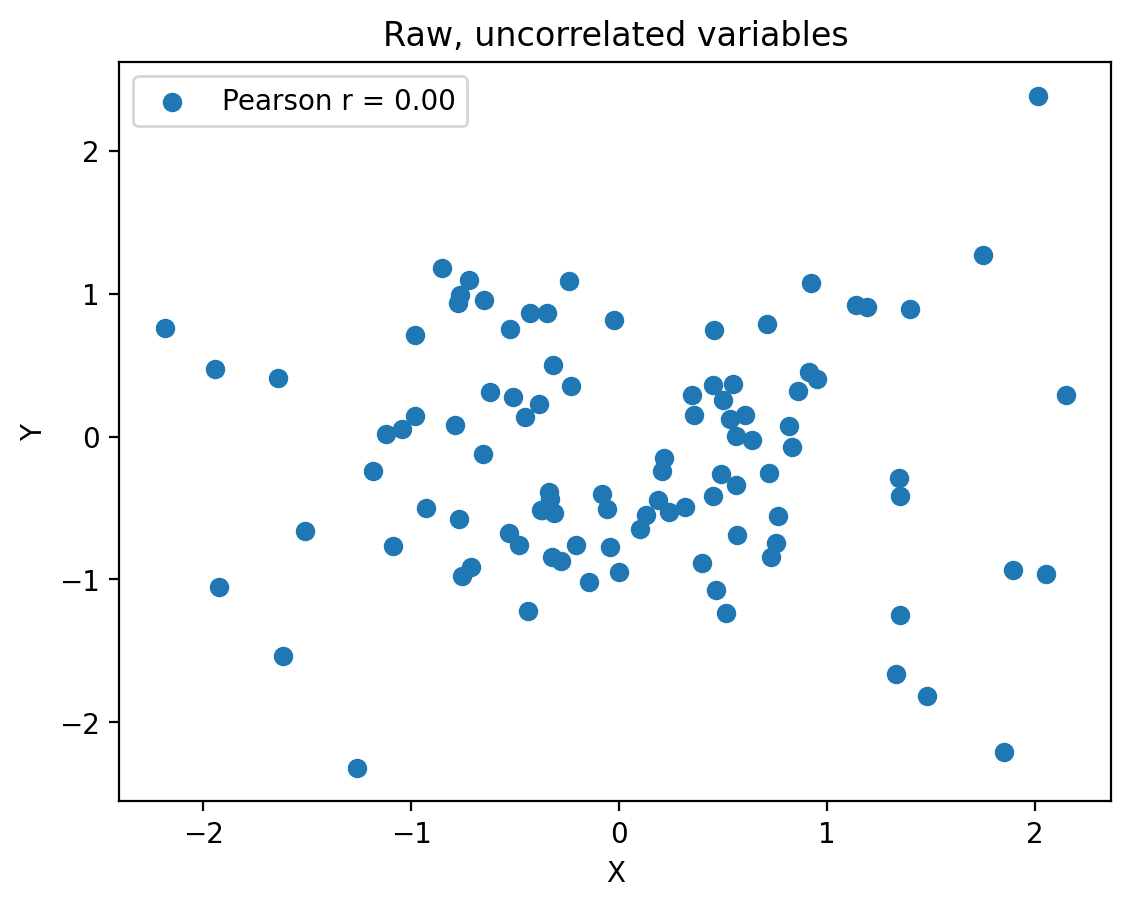

In [158]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(13)

# Generate uncorrelated random data
N = 100
x_random = np.random.randn(N)
y_random = np.random.randn(N)

# Generate a linear trend
x_trend = 0
y_trend = 0

# Add the trend to the random data
x = x_random + x_trend
y = y_random + y_trend

# Calculate the Pearson correlation coefficient
correlation = np.corrcoef(x, y)[0, 1]

# Create the plot
fig, ax = plt.subplots()
ax.scatter(x, y, label=f'Pearson r = {correlation:.2f}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title("Raw, uncorrelated variables")
ax.legend()

plt.show()

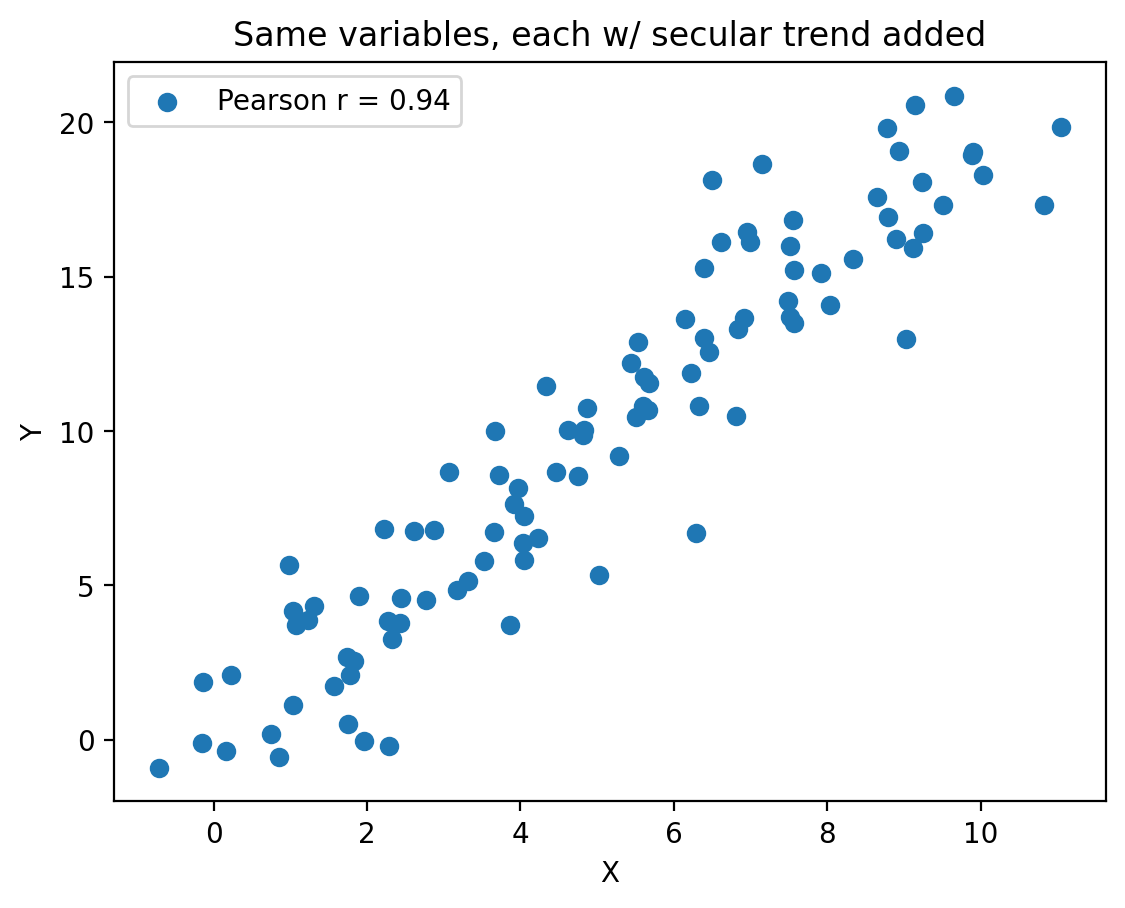

In [159]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(13)

# Generate uncorrelated random data
N = 100
x_random = np.random.randn(N)
y_random = np.random.randn(N)

# Generate a linear trend
x_trend = np.linspace(0, 10, N)
y_trend = np.linspace(0, 20, N)

# Add the trend to the random data
x = x_random + x_trend
y = y_random + y_trend

# Calculate the Pearson correlation coefficient
correlation = np.corrcoef(x, y)[0, 1]

# Create the plot
fig, ax = plt.subplots()
ax.scatter(x, y, label=f'Pearson r = {correlation:.2f}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.title('Same variables, each w/ secular trend added')
ax.legend()

plt.show()

##### Non-monotonic relationships

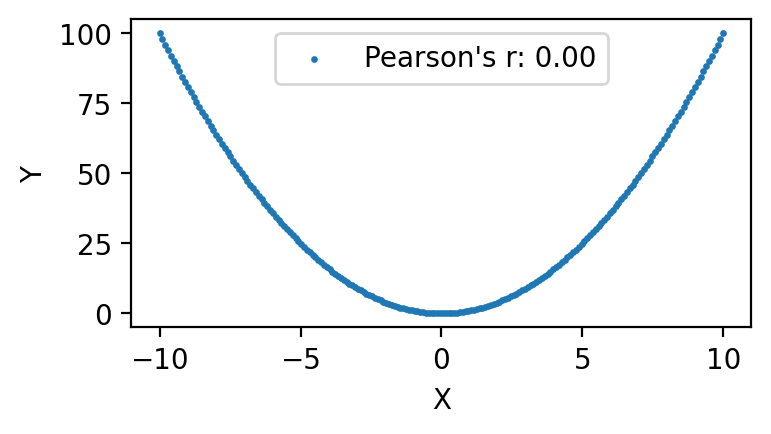

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Generate x values symmetrically around zero
x = np.linspace(-10, 10, 200)

# Compute y values based on x^2
y = x**2

# Compute Pearson's r
r = np.corrcoef(x, y)[0, 1]

# Plot the data
plt.figure(figsize=(4, 2))
plt.scatter(x, y, label=f"Pearson's r: {r:.2f}", s=2)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('')
plt.legend()
#plt.grid(True)
plt.show()

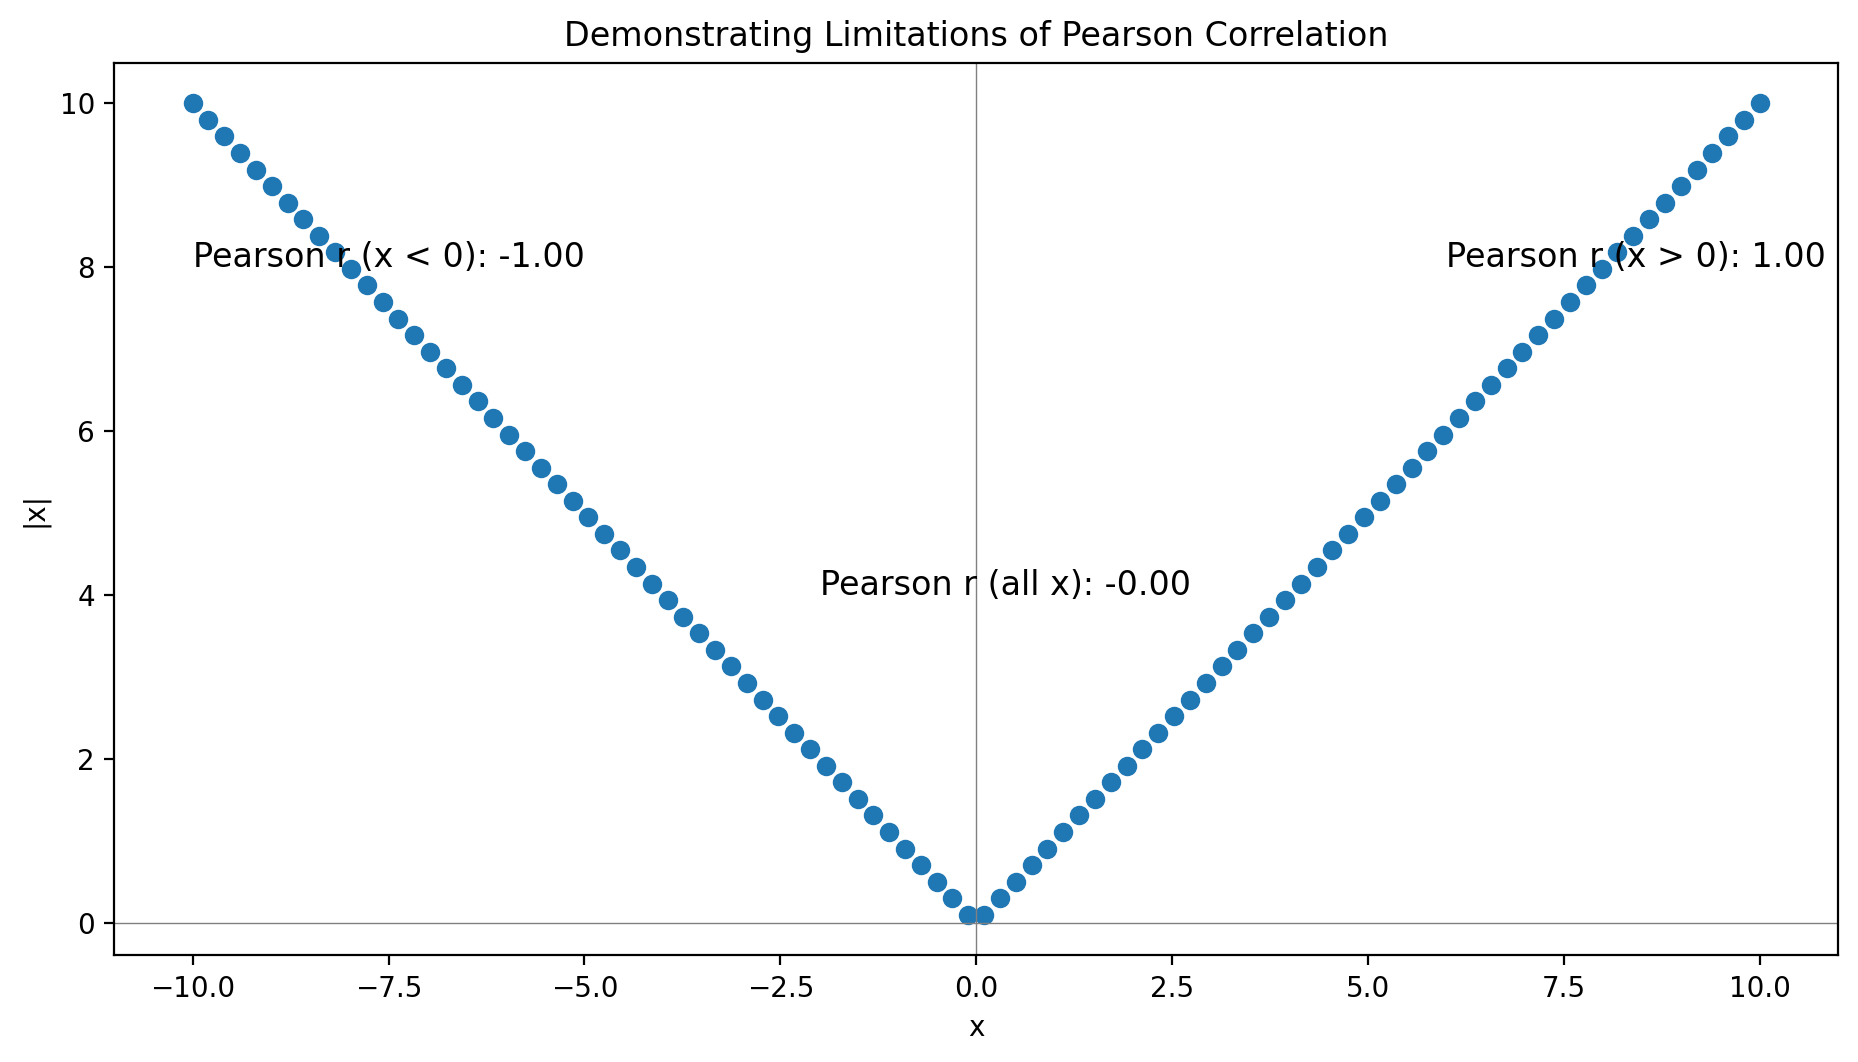

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Generate data
np.random.seed(0)
x = np.linspace(-10, 10, 100)
y = np.abs(x)

# Compute correlations
r_all = pearsonr(x, y)[0]
r_pos = pearsonr(x[x > 0], y[x > 0])[0]
r_neg = pearsonr(x[x < 0], y[x < 0])[0]

# Create plot
fig, ax = plt.subplots(figsize=(9.6, 5.4))
ax.scatter(x, y, label='Data Points')
ax.axhline(0, color='gray', lw=0.5)
ax.axvline(0, color='gray', lw=0.5)

# Annotate with correlation values
ax.text(6, 8, f"Pearson r (x > 0): {r_pos:.2f}", fontsize=12)
ax.text(-10, 8, f"Pearson r (x < 0): {r_neg:.2f}", fontsize=12)
ax.text(-2, 4, f"Pearson r (all x): {r_all:.2f}", fontsize=12)

ax.set_xlabel('x')
ax.set_ylabel('|x|')
ax.set_title('Demonstrating Limitations of Pearson Correlation')
plt.tight_layout()
plt.show()

##### Random chance

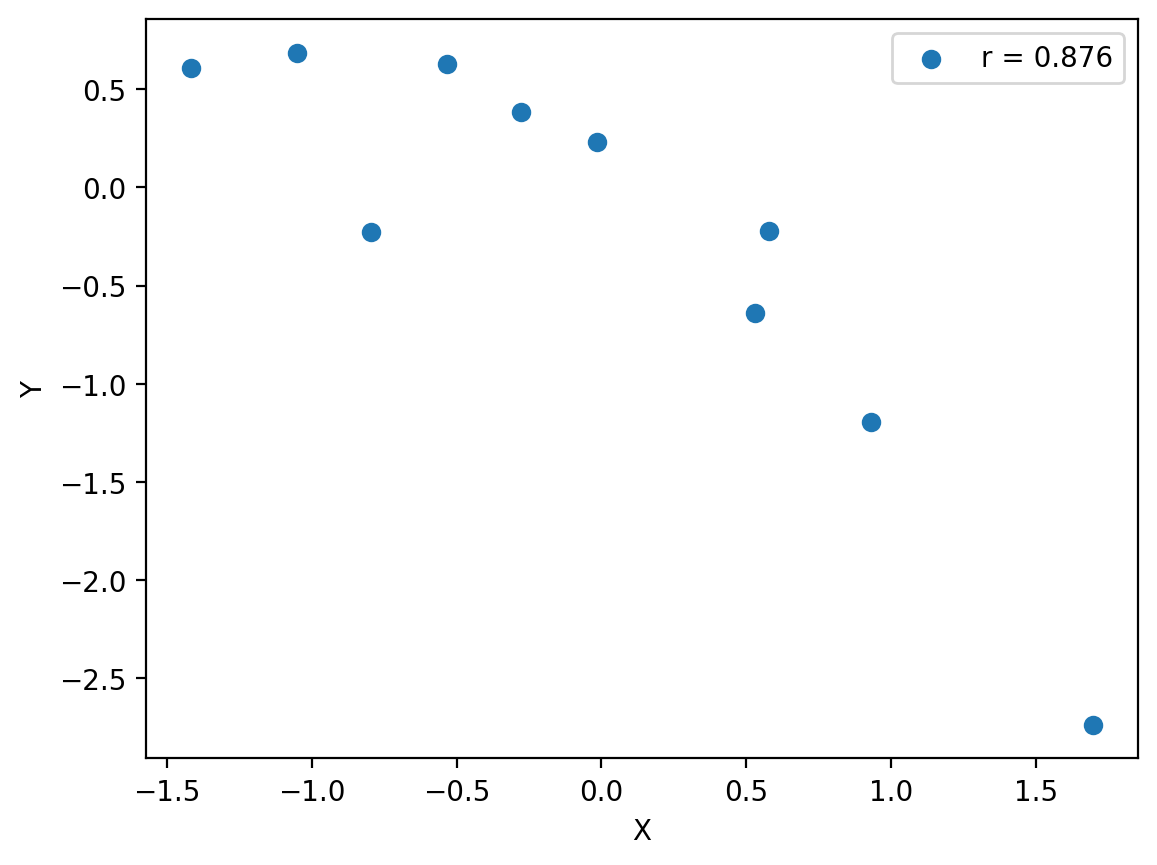

In [173]:
import numpy as np
import matplotlib.pyplot as plt

#np.random.seed(0)

N = 10  # Number of points in each sample
M = 100  # Number of repeated experiments

max_corr = 0
max_x, max_y = None, None

for _ in range(M):
    x_random = np.random.randn(N)
    y_random = np.random.randn(N)
    
    corr = np.abs(np.corrcoef(x_random, y_random)[0, 1])
    
    if corr > max_corr:
        max_corr = corr
        max_x = x_random
        max_y = y_random

# Plot the data points that resulted in the highest magnitude correlation
fig, ax = plt.subplots()
ax.scatter(max_x, max_y, label=f'r = {max_corr:.3f}')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
#plt.title('Spurious Correlation from Random Samples')

plt.show()

##### Sensitivitiy to outliers

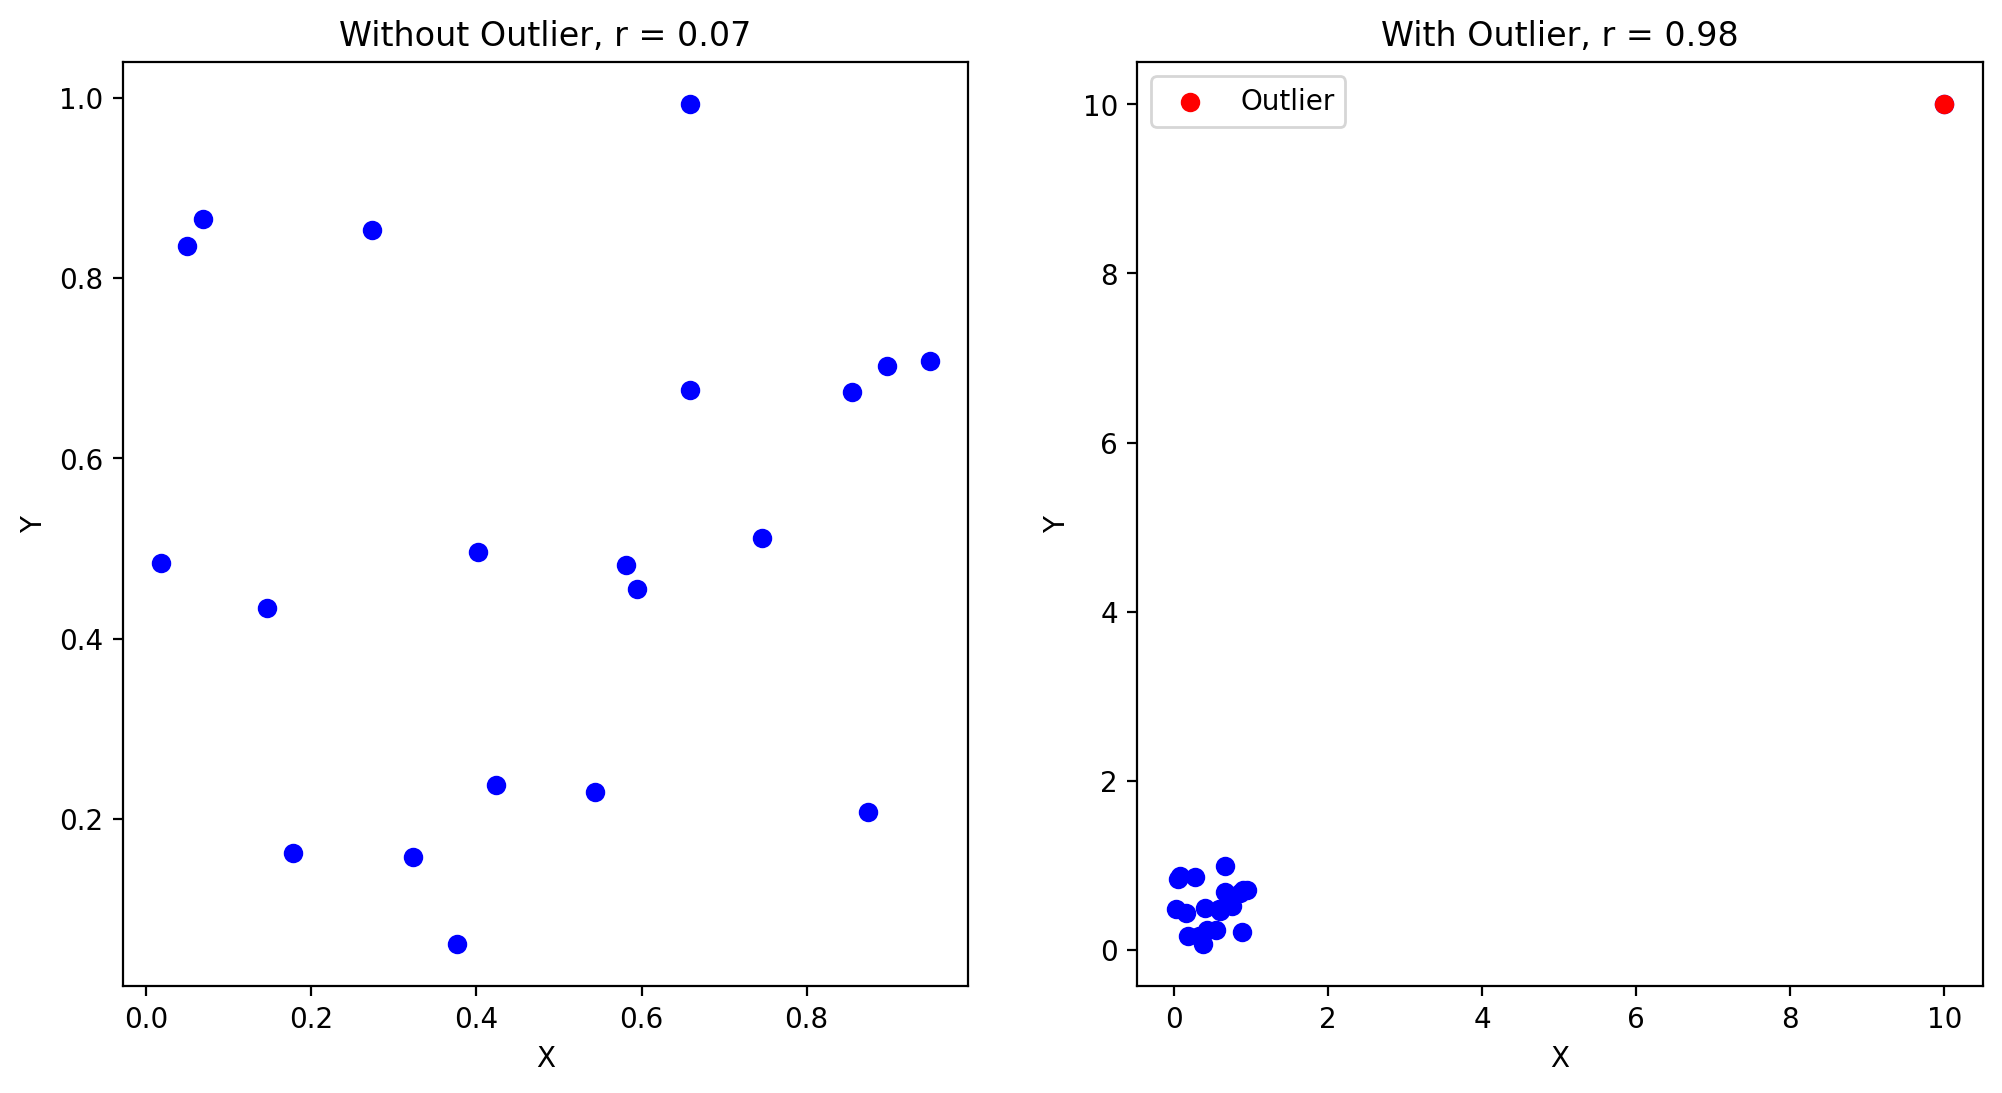

In [180]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

# Generate independent arrays
x = np.random.rand(20)
y = np.random.rand(20)

# Compute the initial Pearson correlation
r_initial, _ = scipy.stats.pearsonr(x, y)

# Add an outlier
x_outlier = np.append(x, [10])
y_outlier = np.append(y, [10])

# Compute the new Pearson correlation with the outlier
r_outlier, _ = scipy.stats.pearsonr(x_outlier, y_outlier)

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot without outlier
ax1.scatter(x, y, color='b')
ax1.set_title(f'Without Outlier, r = {r_initial:.2f}')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')

# Plot with outlier
ax2.scatter(x_outlier, y_outlier, color='b')
ax2.scatter(10, 10, color='r', label='Outlier')
ax2.set_title(f'With Outlier, r = {r_outlier:.2f}')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()

plt.show()

#### Hypothesis test for Pearson's $r$

In [71]:
from scipy import stats
import numpy as np

# Sample data
np.random.seed(0)
x = np.random.randn(30)
y = 2 * x + np.random.randn(30)

# Compute Pearson correlation
r, _ = stats.pearsonr(x, y)

# Compute t-statistic
N = len(x)
t_statistic = (r * np.sqrt(N - 2)) / np.sqrt(1 - r**2)

# Degrees of freedom
df = N - 2

# Compute p-value
p_value = 2 * (1 - stats.t.cdf(np.abs(t_statistic), df))

print(f"r: {r}, t-statistic: {t_statistic}, p-value: {p_value}")
print(stats.pearsonr(x, y))

r: 0.913518817273365, t-statistic: 11.88281496322004, p-value: 1.8771650900362147e-12
PearsonRResult(statistic=0.913518817273365, pvalue=1.8771534139207052e-12)


While Pearson's correlation coefficient $r$ itself makes no assumptions about the distributions of the two variables, the hypothesis test for $r$ *assumes that each variable's population is Gaussian*. 

As always, the concern about normality becomes more relaxed with larger samples due to the central limit theorem. However, with small samples, deviations from normality can distort the test statistics and p-values, increasing the likelihood of false positives (i.e. "Type I errors").

In [91]:
import numpy as np
from scipy.stats import pearsonr, norm, uniform

# Set random seed for reproducibility
seed = np.random.randint(0, 2**32 - 1)
seed2 = np.random.randint(0, 2**32 - 1)

np.random.seed(seed)

# Number of samples
N = 1000

# Specified correlation
rho = 0.1

# Generate normal-distributed variables with specified correlation
np.random.seed(seed)
normal_x = norm.rvs(size=N)
np.random.seed(seed2)
norm2 = norm.rvs(size=N)
normal_y = rho * normal_x + np.sqrt(1 - rho**2) * norm2
r_normal, p_normal = pearsonr(normal_x, normal_y)


# Generate uniform-distributed variables with specified correlation
np.random.seed(seed)
uniform_x = uniform.rvs(size=N)
np.random.seed(seed2)
unif2 = uniform.rvs(size=N)
uniform_y = rho * uniform_x + np.sqrt(1 - rho**2) * unif2
r_uniform, p_uniform = pearsonr(uniform_x, uniform_y)

print(f"Normal distribution: r = {r_normal:.4f}, p-value = {p_normal:.2e}")
print(f"Uniform distribution: r = {r_uniform:.4f}, p-value = {p_uniform:.2e}")

Normal distribution: r = 0.1326, p-value = 2.61e-05
Uniform distribution: r = 0.1341, p-value = 2.09e-05


#### Central Park data

Text(0, 0.5, 'max temp. [F]')

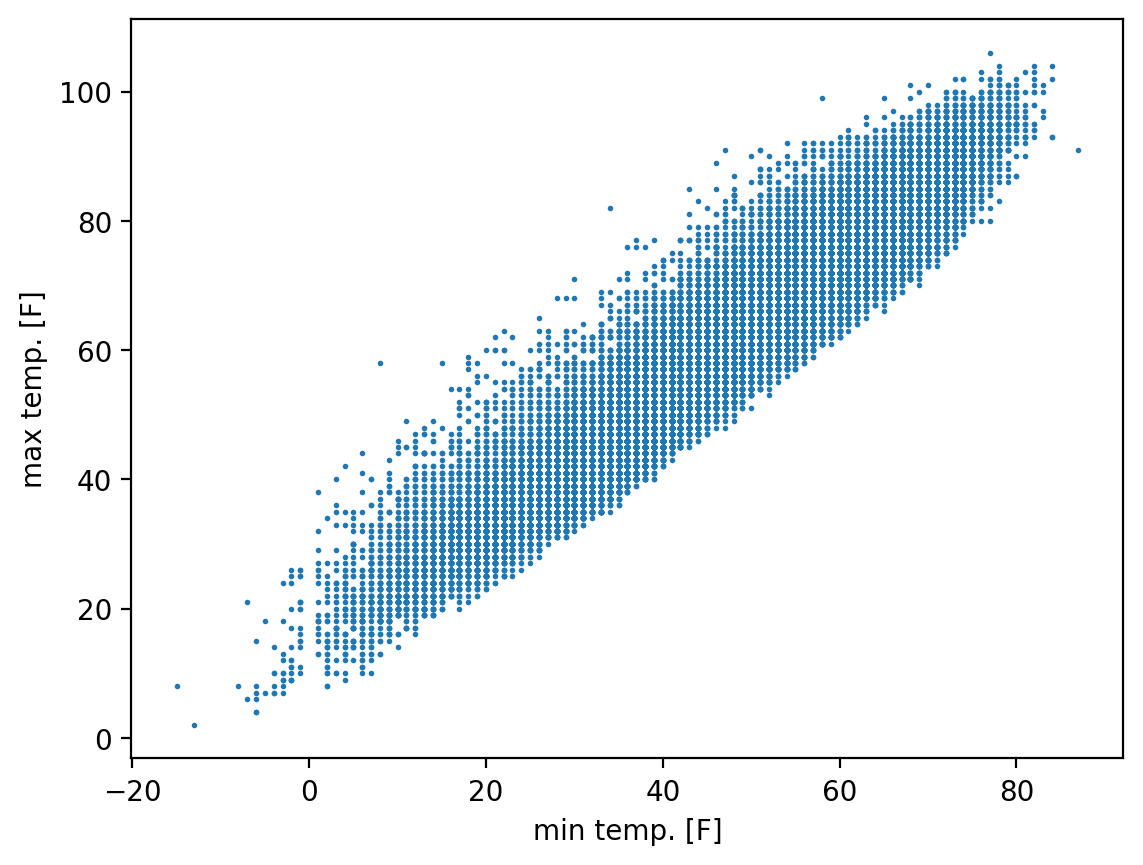

In [119]:
fig, ax = plt.subplots()
ax.scatter(ds_cp["temp_min"], ds_cp["temp_max"], s=1)
ax.set_xlabel("min temp. [F]")
ax.set_ylabel("max temp. [F]")

In [181]:
float(xr.corr(
    ds_cp["temp_min"], 
    ds_cp["temp_max"]))

0.9537972358424263

In [182]:
pf.stats.corr_detrended(
    ds_cp["temp_min"], 
    ds_cp["temp_max"])

0.9535715950209205

### Spearman's rank correlation coefficient

## Anscombe's quartet

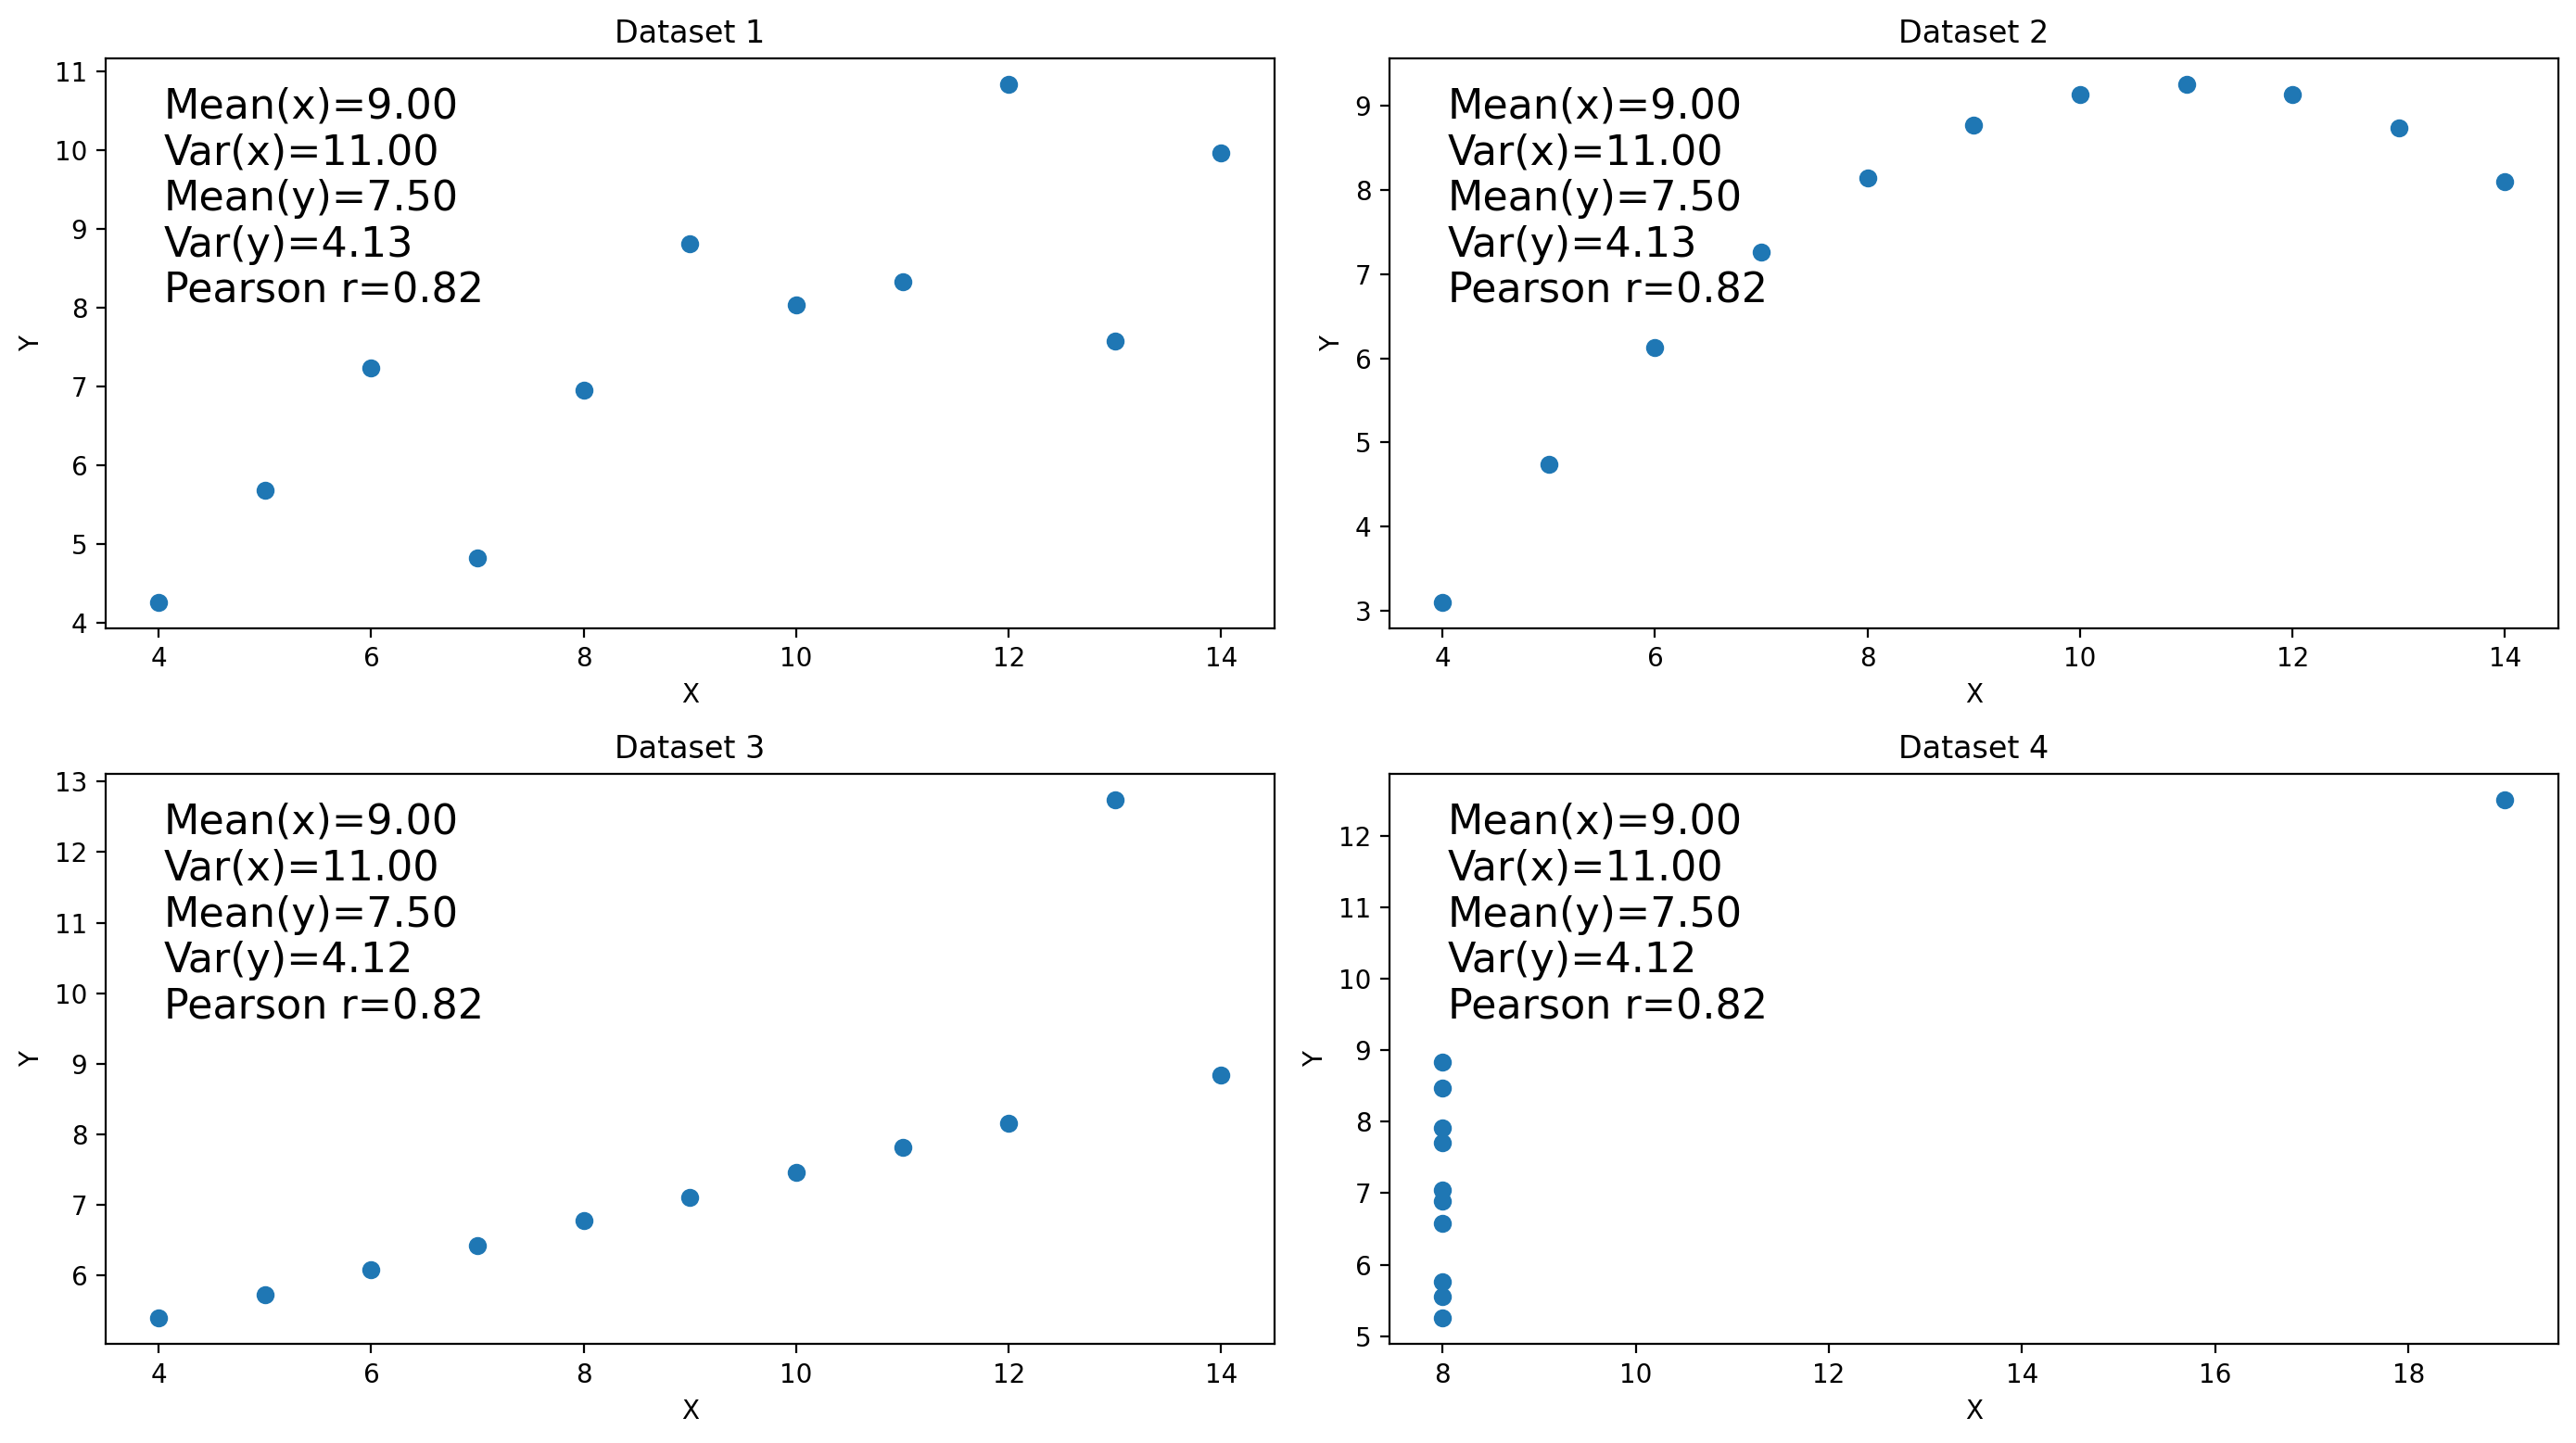

In [60]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# Data for Anscombe's quartet
x1 = np.array([10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5])
y1 = np.array([8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68])
x2 = x1
y2 = np.array([9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74])
x3 = x1
y3 = np.array([7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73])
x4 = np.array([8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8])
y4 = np.array([6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89])



# Define datasets
datasets = {
    "Dataset 1": (x1, y1),
    "Dataset 2": (x2, y2),
    "Dataset 3": (x3, y3),
    "Dataset 4": (x4, y4)
}

# Create 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 7.875))
axs = axs.flatten()

# Loop through datasets to plot each
for i, (title, (x, y)) in enumerate(datasets.items()):
    ax = axs[i]
    ax.scatter(x, y)
    
    # Compute summary statistics
    mean_x, mean_y = np.mean(x), np.mean(y)
    var_x, var_y = np.var(x, ddof=1), np.var(y, ddof=1)
    r, _ = pearsonr(x, y)
    
    # Annotate the plot with these statistics
    stats_text = f"Mean(x)={mean_x:.2f}\nVar(x)={var_x:.2f}\nMean(y)={mean_y:.2f}\nVar(y)={var_y:.2f}\nPearson r={r:.2f}"
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, verticalalignment='top', fontsize=16)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

# Show plot
plt.tight_layout()
plt.show()


## Linear regression

Linear regression makes the following assumptions:

1. **Linearity**: the independent and dependent variables are linearly related.  Applying linear regression for variables with nonlinear relationships can lead to errant predictions.
2. **Independence**: Each value of the independent variable is assumed independent of all its other values, and each value of the dependent variable is assumed independent of all its other values.  For time series or spatial data, this assumption can be violated, leading to biased or inefficient parameter estimates.
3. **Homoscedasticity**: The variance of the residuals is constant across all levels of the independent variable. When this doesn't occur, it's called *heteroscedastic*, whic can lead to inefficient parameter estimates and incorrect conclusions from hypothesis tests.
4. **Normality of Errors**: Not for linear regression itself, but for hypothesis testing.

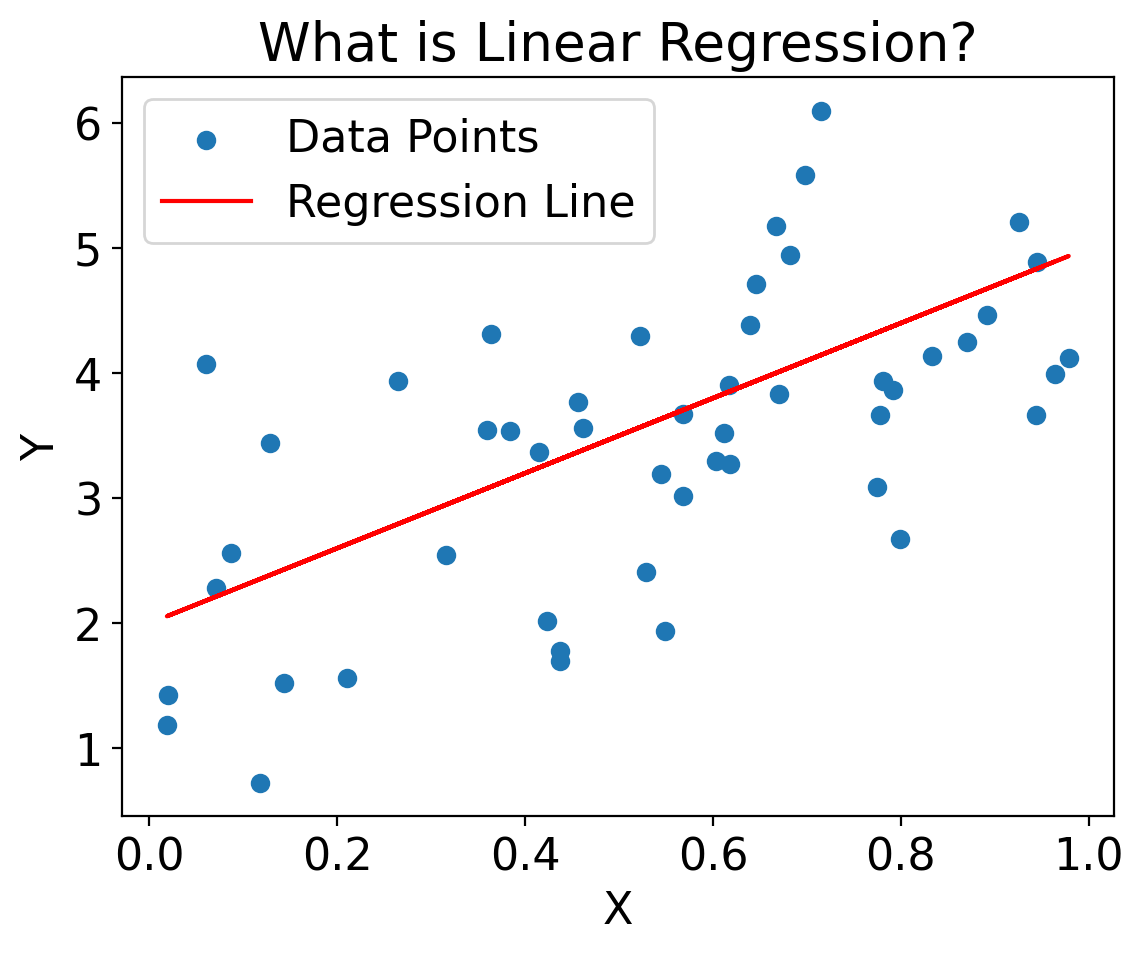

In [200]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)
X = np.random.rand(50)
Y = 2 + 3 * X + np.random.randn(50)

plt.scatter(X, Y, label='Data Points')
plt.plot(X, 2 + 3 * X, label='Regression Line', color='red')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('What is Linear Regression?')
plt.show()

/var/folders/3g/s0brcg452zn0z3962qt_0pn00000gn/T/ipykernel_10782/161289806.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  run = float(line_X[-1] - line_X[0])


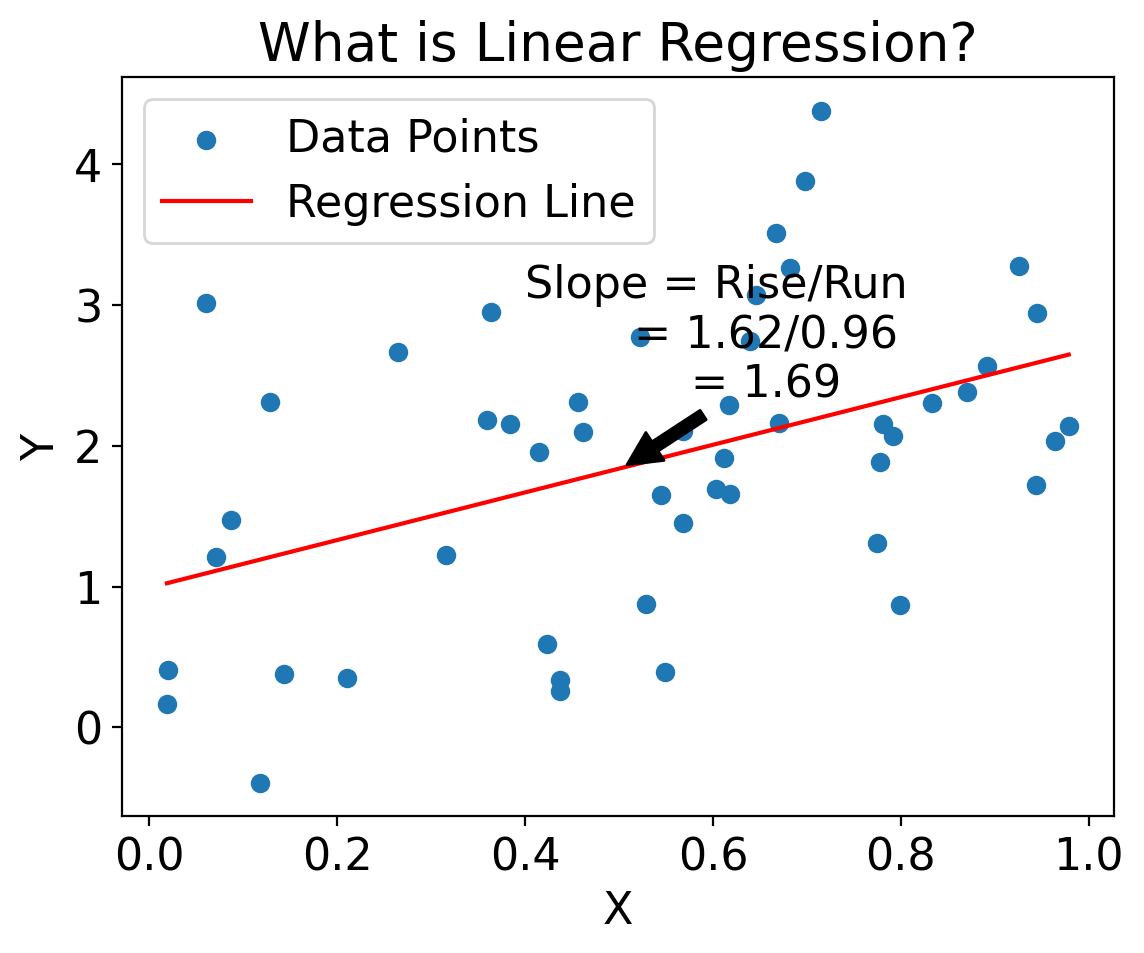

In [209]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Generate some synthetic data
np.random.seed(0)
X = np.random.rand(50)
Y = 2 * X + 1 + np.random.randn(50)

# Fit a simple linear model
model = LinearRegression()
model.fit(X.reshape(-1, 1), Y)
line_X = np.linspace(min(X), max(X), 100).reshape(-1, 1)
line_y = model.predict(line_X)

# Calculate rise and run for annotation
rise = float(line_y[-1] - line_y[0])
run = float(line_X[-1] - line_X[0])
slope = rise / run

# Create the plot
plt.scatter(X, Y, label='Data Points')
plt.plot(line_X, line_y, label='Regression Line', color='red')

# Annotate slope on the line
mid_point_index = len(line_X) // 2
mid_point_X = line_X[mid_point_index]
mid_point_y = model.predict(mid_point_X.reshape(1, -1))
plt.annotate(
    f'Slope = Rise/Run\n       = {rise:.2f}/{run:.2f}\n       = {slope:.2f}',
    xy=(mid_point_X[0], mid_point_y[0]),
    xytext=(mid_point_X[0] + 0.1, mid_point_y[0] + 0.5),
    arrowprops=dict(facecolor='black', shrink=0.05),
    horizontalalignment='center'
)

plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('What is Linear Regression?')
plt.show()


### Residuals

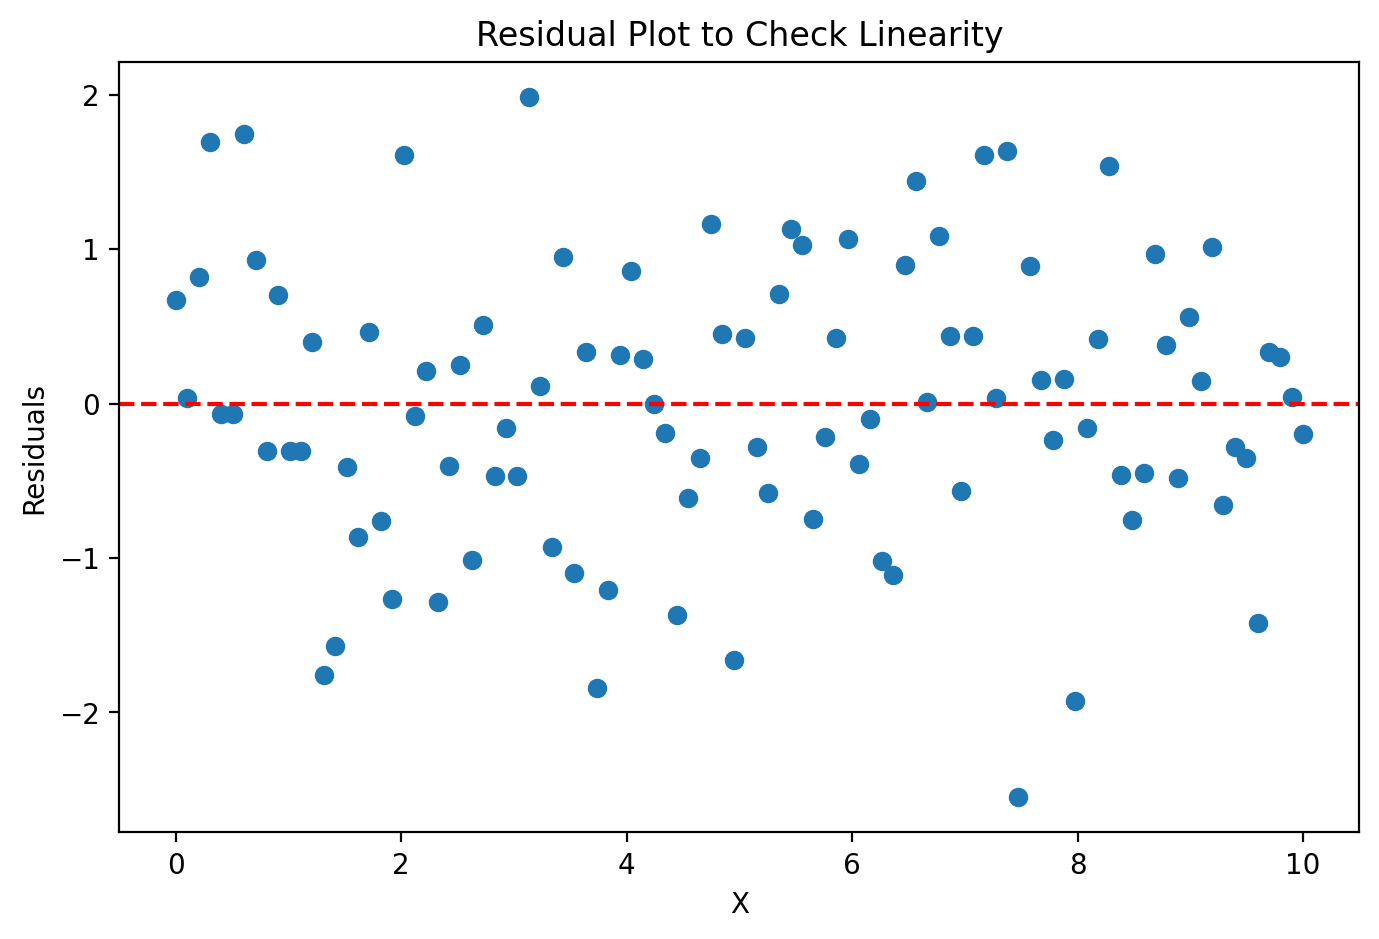

In [97]:
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 10, 100)
y = 2 * X + 1 + np.random.normal(0, 1, 100)

# Fit a simple linear model
coeff = np.polyfit(X, y, 1)
y_pred = np.polyval(coeff, X)

# Calculate residuals
residuals = y - y_pred

# Create residual plot
plt.figure(figsize=(8, 5))
plt.scatter(X, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("X")
plt.ylabel("Residuals")
plt.title("Residual Plot to Check Linearity")
plt.show()

In [98]:
import panel as pn
import pandas as pd
from bokeh.models import Span
from bokeh.plotting import figure

# Create DataFrame
df = pd.DataFrame({'X': X, 'residuals': residuals})

# Define the plotting function
def plot_with_smoothing(smoothing):
    p = figure(width=800, height=400, title='Residual Plot with Smoothing Curve')
    p.scatter(df['X'], df['residuals'], color='blue')
    if smoothing:
        p.line(df['X'], df['residuals'].rolling(window=5).mean(), color='green', legend_label='Smoothing Curve')
    hline = Span(location=0, dimension='width', line_color='red', line_dash='dashed')
    p.renderers.extend([hline])
    return p

# Create Panel interactive widget
smoothing_toggle = pn.widgets.Toggle(name='Add Smoothing Curve', value=False)
interact = pn.interact(plot_with_smoothing, smoothing=smoothing_toggle)
pn.Row(interact[1][0], interact[0]).servable()

Row
    [0] Bokeh(figure, name='interactive04578')
    [1] Column
        [0] Toggle(name='Add Smoothing Curve')

### Homeskedasticity

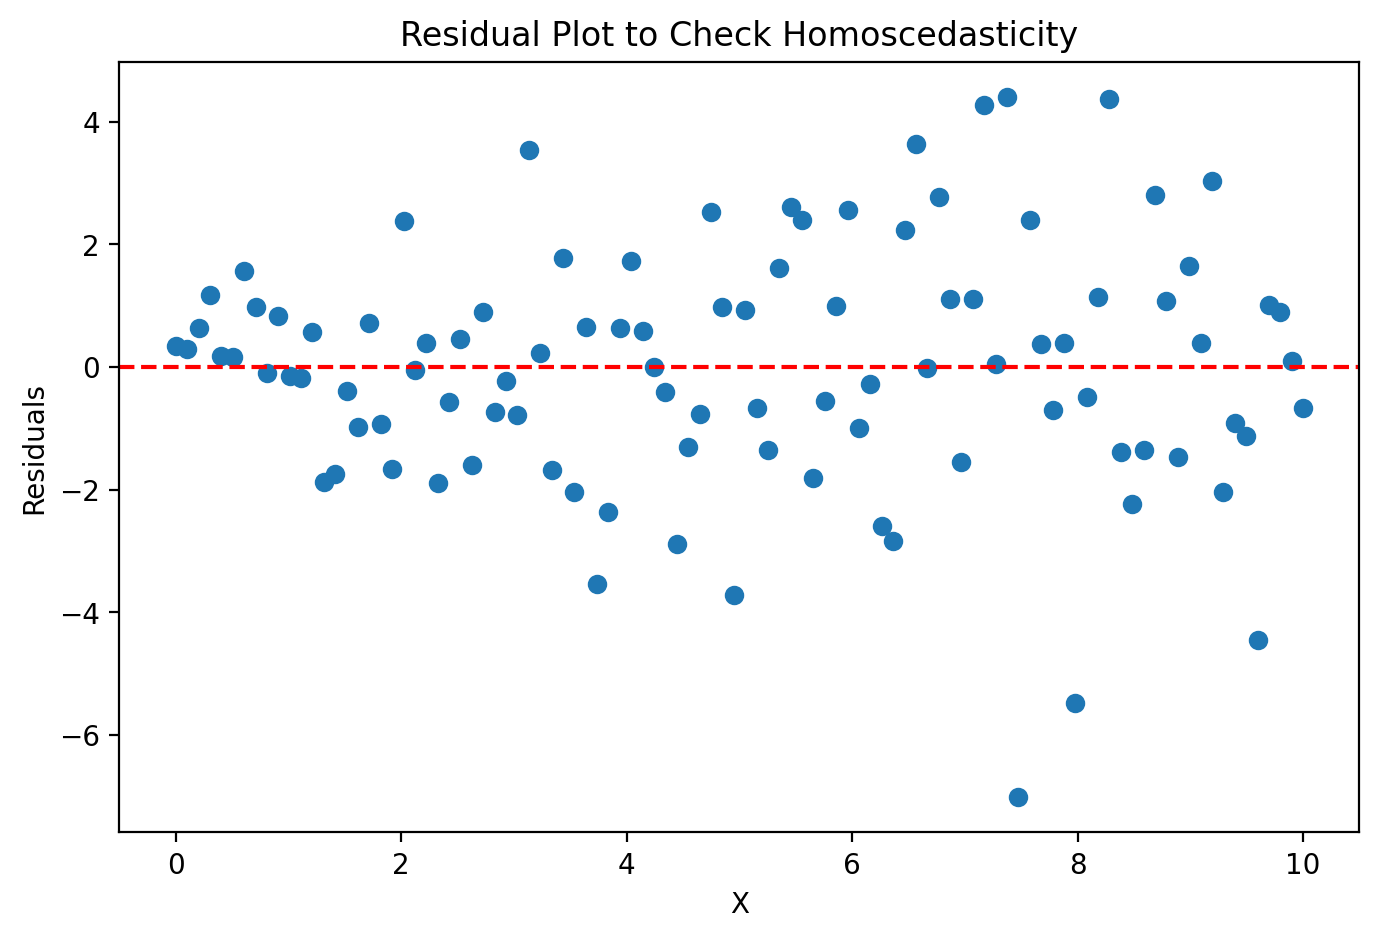

In [99]:
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 10, 100)
y = 2 * X + 1 + np.random.normal(0, np.sqrt(X), 100)

# Fit a simple linear model
coeff = np.polyfit(X, y, 1)
y_pred = np.polyval(coeff, X)

# Calculate residuals
residuals = y - y_pred

# Create residual plot
plt.figure(figsize=(8, 5))
plt.scatter(X, residuals)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("X")
plt.ylabel("Residuals")
plt.title("Residual Plot to Check Homoscedasticity")
plt.show()

In [100]:
import panel as pn
import pandas as pd
from bokeh.models import Span
from bokeh.plotting import figure

# Define the plotting function
def plot_homoscedasticity(constant_variance=True):
    np.random.seed(42)
    if constant_variance:
        y = 2 * X + 1 + np.random.normal(0, 1, 100)
    else:
        y = 2 * X + 1 + np.random.normal(0, np.sqrt(X), 100)

    # Calculate residuals
    coeff = np.polyfit(X, y, 1)
    y_pred = np.polyval(coeff, X)
    residuals = y - y_pred

    # Create Bokeh plot
    p = figure(width=800, height=400, title='Residual Plot to Check Homoscedasticity')
    p.scatter(X, residuals, color='blue')
    hline = Span(location=0, dimension='width', line_color='red', line_dash='dashed')
    p.renderers.extend([hline])
    return p

# Create Panel interactive widget
toggle = pn.widgets.Toggle(name='Constant Variance', value=True)
interact = pn.interact(plot_homoscedasticity, constant_variance=toggle)
pn.Row(interact[1][0], interact[0]).servable()

Row
    [0] Bokeh(figure, name='interactive04612')
    [1] Column
        [0] Toggle(name='Constant Variance', value=True)

### Least squares

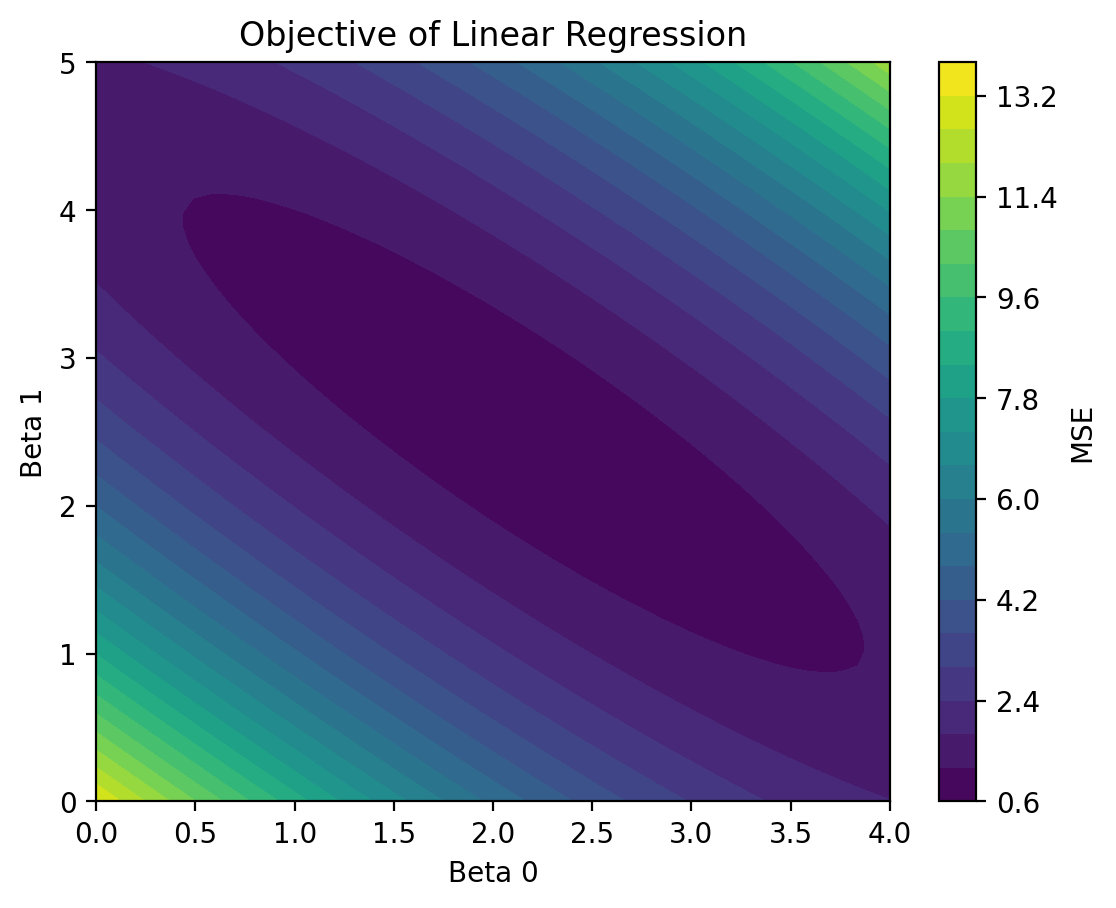

In [188]:
# Given the above X, Y
from sklearn.metrics import mean_squared_error

np.random.seed(0)
X = np.random.rand(50)
Y = 2 + 3 * X + np.random.randn(50)

beta_0 = np.linspace(0, 4, 50)
beta_1 = np.linspace(0, 5, 50)
mse_values = np.zeros((50, 50))

for i, b0 in enumerate(beta_0):
    for j, b1 in enumerate(beta_1):
        mse_values[i, j] = mean_squared_error(Y, b0 + b1 * X)

plt.contourf(beta_0, beta_1, mse_values, levels=20)
plt.colorbar(label='MSE')
plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.title('Objective of Linear Regression')
plt.show()

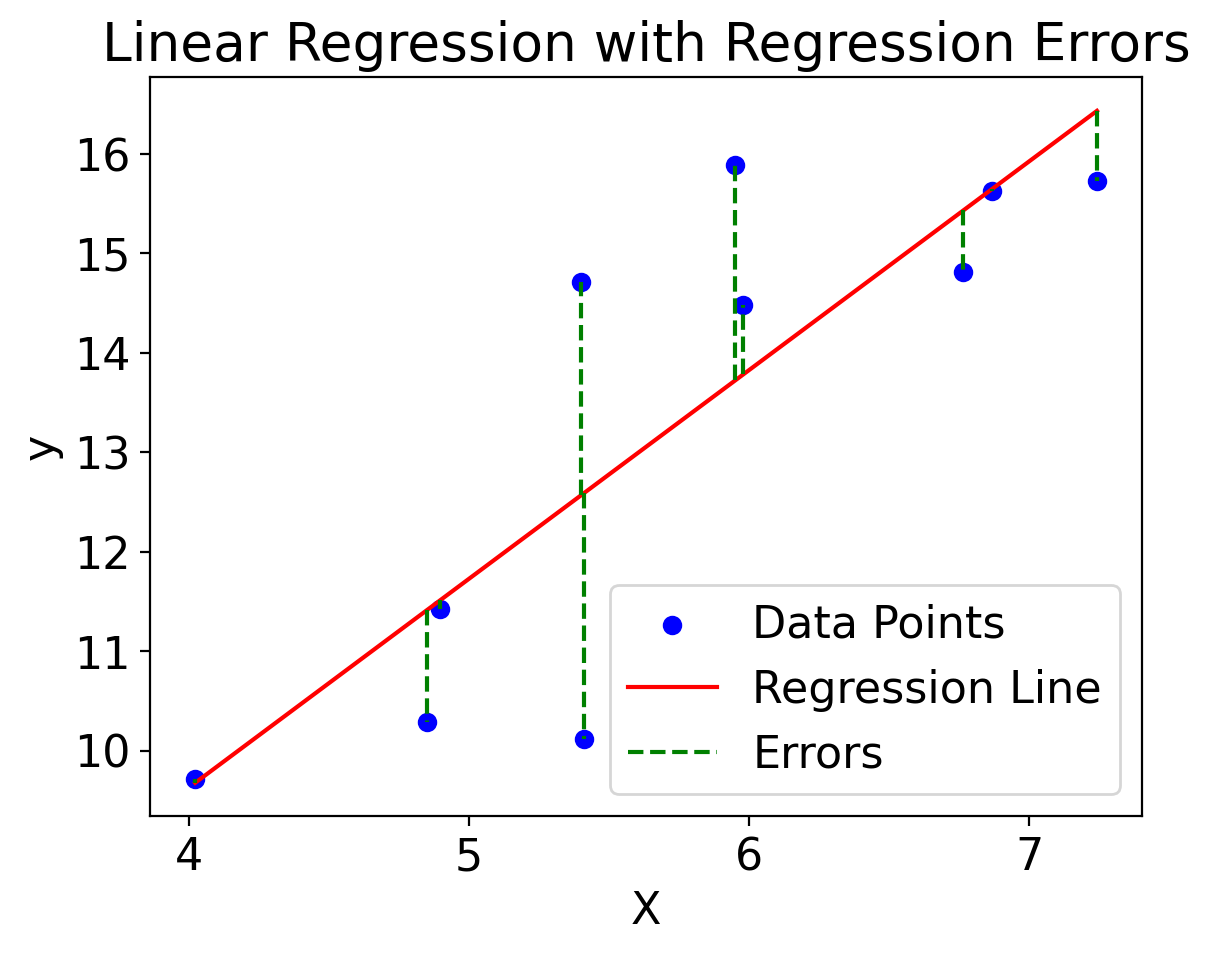

In [197]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

# Generate some synthetic data
np.random.seed(0)
X = np.random.normal(5, 1, 10).reshape(-1, 1)  # Independent variable
y = 2 * X.squeeze() + 1 + np.random.normal(0, 2, 10)  # Dependent variable

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)
line_X = np.linspace(min(X), max(X), 100).reshape(-1, 1)
line_y = model.predict(line_X)


# Plot the data points
plt.scatter(X, y, color='blue', label='Data Points')

# Plot the regression line
plt.plot(line_X, line_y, color='red', label='Regression Line')

# Calculate the y-values on the regression line
predicted_y = model.predict(X)

# Plot the errors as vertical lines
plt.vlines(X, predicted_y, y, colors='green', linestyles='dashed', label='Errors')

# Add labels and title
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression with Regression Errors')
plt.legend()
plt.show()


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
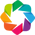

Row
    [0] Column
        [0] FloatSlider(end=5.0, name='Slope', value=2.5)
        [1] FloatSlider(end=20.0, name='Intercept', step=1.0, value=10.0)
    [1] ParamFunction(function, _pane=HoloViews, defer_load=False)

In [260]:
import numpy as np
import holoviews as hv
import panel as pn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

hv.extension('bokeh')

# Generate some synthetic data
np.random.seed(42)
X = np.random.rand(100) * 10
y = 2.5 * X + 10 + np.random.randn(100) * 5

# Fit a least squares linear regression model
X_reshaped = X.reshape(-1, 1)
model = LinearRegression()
model.fit(X_reshaped, y)

# Predict using the model
y_pred = model.predict(X_reshaped)
mse_least_squares = mean_squared_error(y, y_pred)

# Function to calculate the user-defined regression line and MSE
def regression_line(slope, intercept):
    user_y_pred = slope * X + intercept
    mse_user = mean_squared_error(y, user_y_pred)
    
    # Plot the data, least squares line, and user-defined line
    scatter = hv.Scatter((X, y), 'X', 'y')
    ls_line = hv.Curve((X, y_pred), 'X', 'y').opts(color='blue', line_width=2)
    user_line = hv.Curve((X, user_y_pred), 'X', 'y').opts(color='red', line_width=2)
    
    return (scatter * ls_line * user_line).opts(
        title=f'MSE (Least Squares): {mse_least_squares:.2f},\nMSE (User): {mse_user:.2f}'
    ), mse_user

# Create sliders for slope and intercept
slope_slider = pn.widgets.FloatSlider(name='Slope', start=0.0, end=5.0, step=0.1, value=2.5)
intercept_slider = pn.widgets.FloatSlider(name='Intercept', start=0.0, end=20.0, step=1.0, value=10.0)

# Interactive function to update plot based on slider values
@pn.depends(slope=slope_slider, intercept=intercept_slider)
def interactive_regression(slope, intercept):
    return regression_line(slope, intercept)[0]

# Display the plot and sliders
pn.Row(
    pn.Column(slope_slider, intercept_slider),
    interactive_regression
).servable()

### Linear regression implementations in python

Most of the implementation don't work if there are any `NaN` values.  So it's helpful to write a helper function using `xarray` to create versions of your X and Y arrays with all `NaN` values dropped and with identical coordinate values:

In [264]:
ds_cp["temp_max"]

<xarray.DataArray 'temp_max' (time: 56520)>
array([29., 27., 35., ..., 65., 63., 66.])
Coordinates:
  * time     (time) datetime64[ns] 1869-01-01 1869-01-02 ... 2023-09-30

In [267]:
ds_cp["temp_max"].dropna("time")

<xarray.DataArray 'temp_max' (time: 56449)>
array([29., 27., 35., ..., 65., 63., 66.])
Coordinates:
  * time     (time) datetime64[ns] 1869-01-01 1869-01-02 ... 2023-09-30

In [265]:
xr.align(ds_cp["temp_min"], ds_cp["temp_max"])

(<xarray.DataArray 'temp_min' (time: 56520)>
 array([19., 21., 27., ..., 56., 59., 57.])
 Coordinates:
   * time     (time) datetime64[ns] 1869-01-01 1869-01-02 ... 2023-09-30,
 <xarray.DataArray 'temp_max' (time: 56520)>
 array([29., 27., 35., ..., 65., 63., 66.])
 Coordinates:
   * time     (time) datetime64[ns] 1869-01-01 1869-01-02 ... 2023-09-30)

In [268]:
def arrs_for_regr(arr1, arr2):
    """Return views of arr1 and arr2 with NaNs dropped and aligned."""
    return xr.align(arr1.dropna(arr1.dims[0]), arr2.dropna(arr2.dims[0]))

#### `numpy.polyfit`

In [269]:
tmin_for_regr, tmax_for_regr = arrs_for_regr(ds_cp["temp_min"], ds_cp["temp_max"])

In [270]:
np.polyfit(tmin_for_regr, tmax_for_regr, 1)

array([ 1.05064541, 12.35569893])

#### `scipy.stats.linregress`

In [271]:
scipy.stats.linregress(tmin_for_regr, tmax_for_regr)

LinregressResult(slope=1.050645409563477, intercept=12.355698929858043, rvalue=0.9537972358424263, pvalue=0.0, stderr=0.0013936741129371801, intercept_stderr=0.06941543775966094)

### `scikit-learn`

In [272]:
from sklearn.linear_model import LinearRegression

skl_lsm = LinearRegression().fit(np.array([tmin_for_regr.values]).transpose(), tmax_for_regr)
print(skl_lsm.coef_, skl_lsm.intercept_)

[1.05064541] 12.35569892985805


In [273]:
tmax_ls_predic = 12.35 + 1.05 * ds_cp["temp_min"]

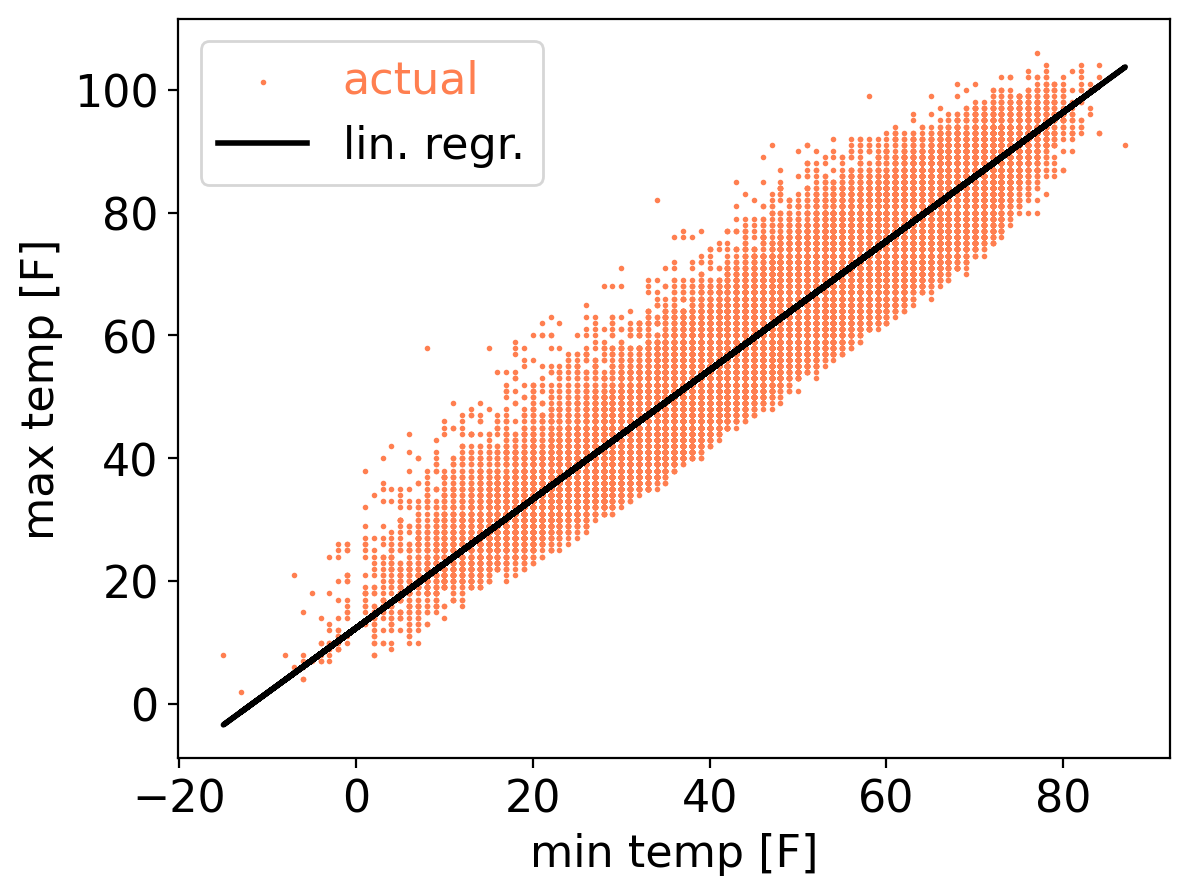

In [274]:
plt.scatter(ds_cp["temp_min"], ds_cp["temp_max"], s=1, color="coral", label="actual")
plt.plot(ds_cp["temp_min"], tmax_ls_predic, color="black", linewidth=2, label="lin. regr.")
plt.xlabel("min temp [F]")
plt.ylabel("max temp [F]")
plt.legend(labelcolor="linecolor")